In [7]:
# Cleanup script for requirements.txt
clean_lines = []
with open("requirements.txt", "r") as f:
    for line in f:
        # Keep only package names and versions, remove lines with '@' or paths
        if "@" not in line:
            clean_lines.append(line.split("#")[0].strip())  # Remove comments

with open("requirements_cleaned.txt", "w") as f:
    f.write("\n".join(clean_lines))


In [2]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to parse .obj files and extract coordinates
def parse_obj_file(file_path):
    coordinates = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):  # Extract vertex coordinates
                parts = line.split()
                x, y, z = map(float, parts[1:4])
                coordinates.append([x, y, z])
    return np.array(coordinates)

# Path to the root directory containing folders of individuals
root_dir = "C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas"
labels = []
features = []

# Traverse through folders and parse .obj files
for individual_id, folder in enumerate(os.listdir(root_dir)):
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):  # Ensure it's a directory
        for obj_file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, obj_file)
            if file_path.endswith('.obj'):
                coordinates = parse_obj_file(file_path)
                
                # Feature Engineering: Example feature extraction
                velocities = []
                for i in range(1, len(coordinates)):
                    delta = coordinates[i] - coordinates[i - 1]
                    velocities.append(np.linalg.norm(delta))  # Euclidean distance
                    
                # Aggregate features (e.g., mean, std of velocities)
                features.append([np.mean(velocities), np.std(velocities)])
                labels.append(individual_id)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Standardize features for algorithms like SVM and Logistic Regression
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# List of classifiers to evaluate
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Evaluate each classifier
results = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate metrics (precision, recall, F1-score)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Accuracy": accuracy
    }
    print(f"{name} Results:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  Accuracy: {accuracy:.4f}\n")

# Save the best model based on F1-score
best_model_name = max(results, key=lambda x: results[x]["F1-score"])
best_model = classifiers[best_model_name]
import joblib
joblib.dump(best_model, 'best_drawing_identifier_model.pkl')
print(f"Best model saved: {best_model_name}")


Random Forest Results:
  Precision: 0.7500
  Recall: 0.6250
  F1-score: 0.6750
  Accuracy: 0.6250

Gradient Boosting Results:
  Precision: 0.7500
  Recall: 0.5000
  F1-score: 0.5625
  Accuracy: 0.5000

SVM Results:
  Precision: 0.7500
  Recall: 0.6250
  F1-score: 0.6750
  Accuracy: 0.6250

Logistic Regression Results:
  Precision: 0.7500
  Recall: 0.6250
  F1-score: 0.6750
  Accuracy: 0.6250

Decision Tree Results:
  Precision: 0.5000
  Recall: 0.2500
  F1-score: 0.3125
  Accuracy: 0.2500

Best model saved: Random Forest


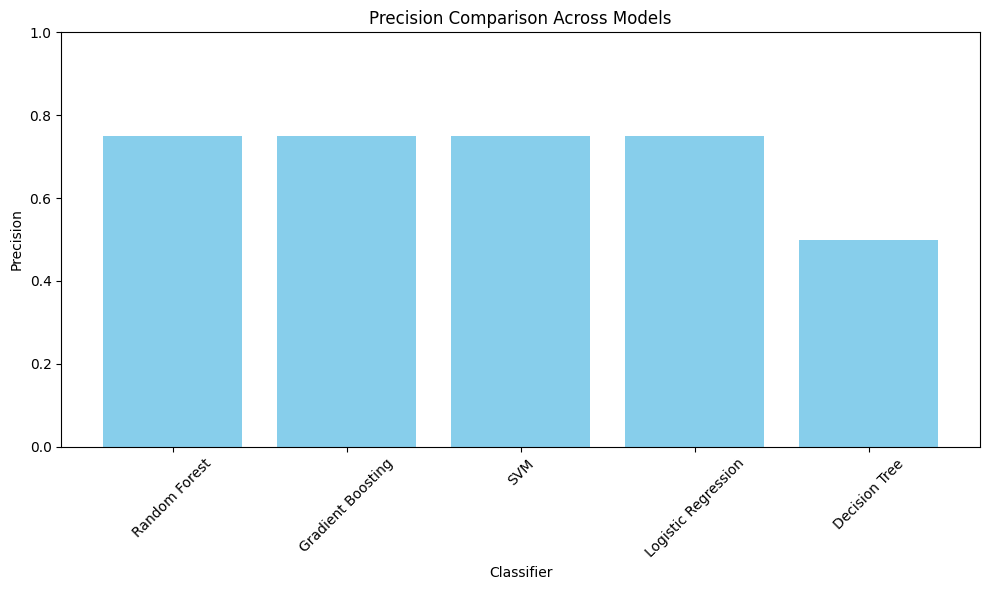

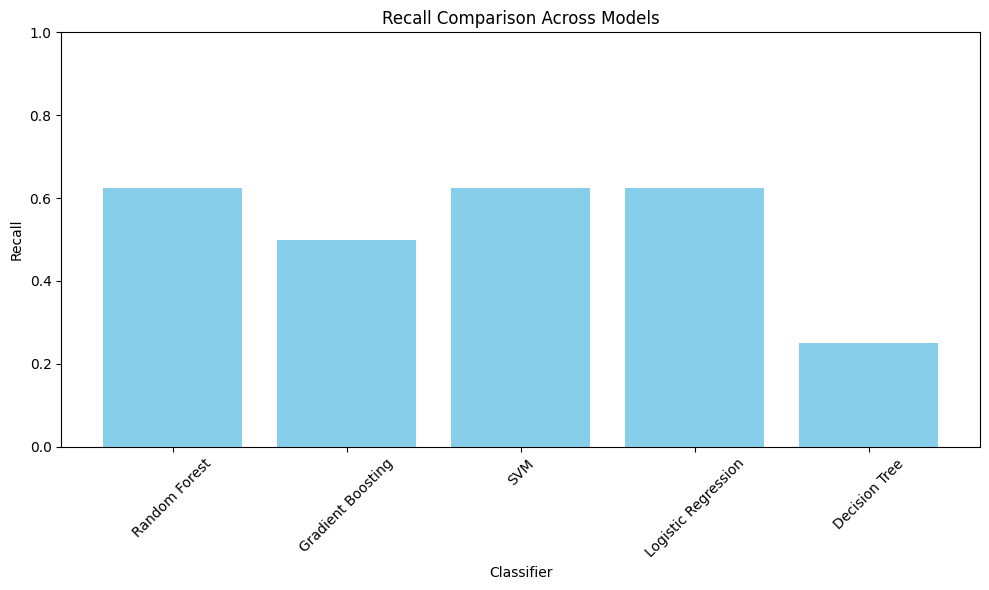

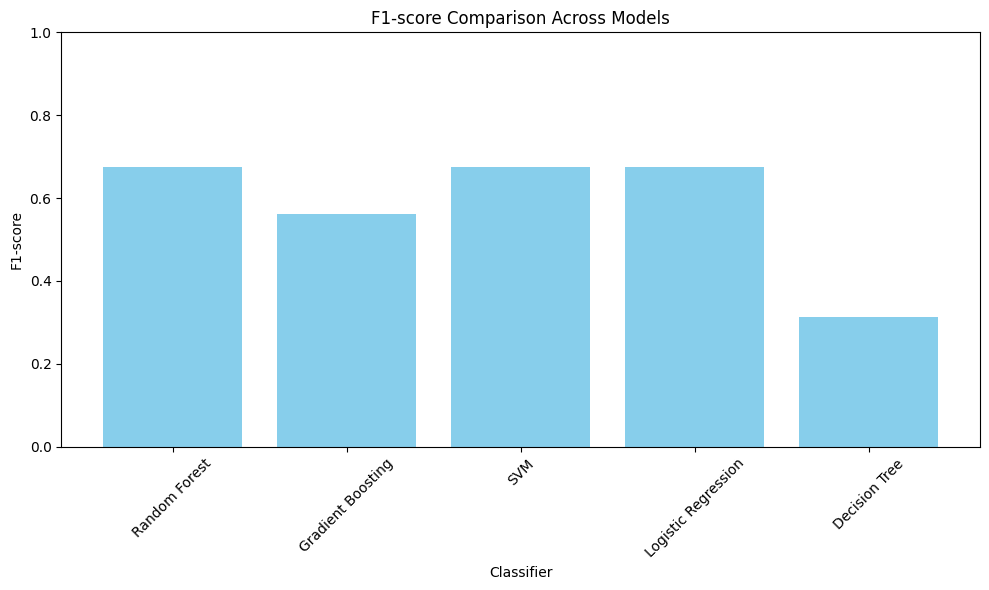

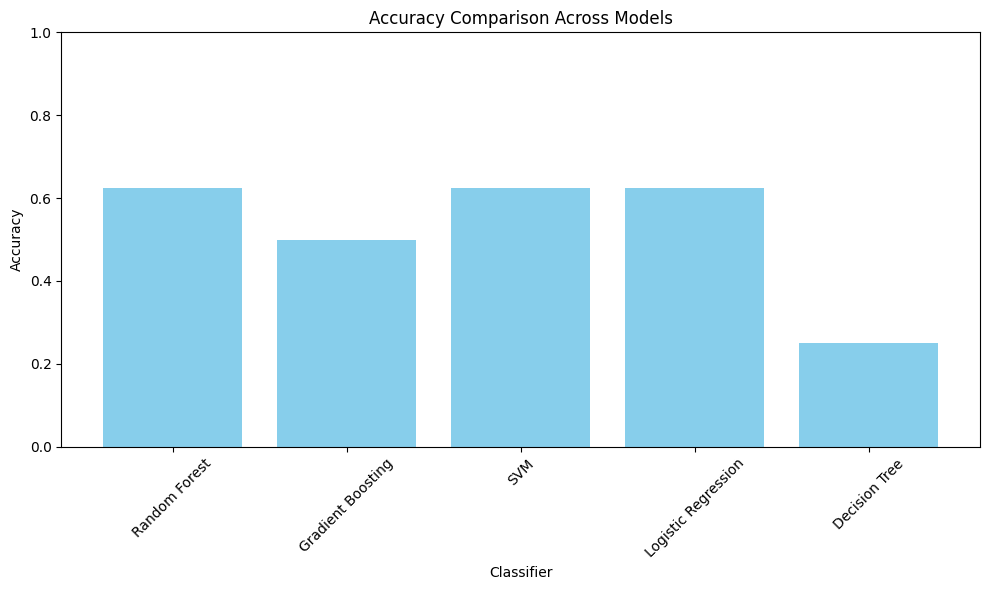

In [3]:
# Plotting metrics
def plot_metrics(results):
    metrics = ["Precision", "Recall", "F1-score", "Accuracy"]
    for metric in metrics:
        values = [results[clf][metric] for clf in results]
        plt.figure(figsize=(10, 6))
        plt.bar(results.keys(), values, color='skyblue')
        plt.title(f"{metric} Comparison Across Models")
        plt.ylabel(metric)
        plt.xlabel("Classifier")
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

plot_metrics(results)


In [35]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [27]:
def predict_individual(model_path, input_obj_path):
    """
    Predict which individual an input .obj file belongs to.
    :param model_path: Path to the saved model file (e.g., .pkl).
    :param input_obj_path: Path to the input .obj file.
    :return: Predicted individual ID.
    """
    # Load the trained model
    classifier = joblib.load(model_path)
    
    # Parse the .obj file to extract x, y, z coordinates
    coordinates = parse_obj_file(input_obj_path)
    
    # Feature Engineering: Calculate velocities
    velocities = []
    for i in range(1, len(coordinates)):
        delta = coordinates[i] - coordinates[i - 1]
        velocities.append(np.linalg.norm(delta))  # Euclidean distance
    
    # Aggregate features (e.g., mean, std of velocities)
    input_features = np.array([np.mean(velocities), np.std(velocities)]).reshape(1, -1)
    
    # Predict using the model
    predicted_label = classifier.predict(input_features)
    return predicted_label[0]

# Example Usage
model_path = 'drawing_identifier_model.pkl'  # Path to saved model
input_obj_path = 'C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas/Nilu/n7.obj.obj'     # Path to input .obj file

predicted_individual = predict_individual(model_path, input_obj_path)
print(f"The input drawing belongs to Individual {predicted_individual}")


The input drawing belongs to Individual 2


In [33]:
def predict_individual(model_path, input_obj_path, individual_names):
    """
    Predict which individual an input .obj file belongs to.
    :param model_path: Path to the saved model file (e.g., .pkl).
    :param input_obj_path: Path to the input .obj file.
    :param individual_names: Dictionary mapping individual IDs to names.
    :return: Predicted individual name.
    """
    import joblib
    
    # Load the trained model
    classifier = joblib.load(model_path)
    
    # Parse the .obj file to extract x, y, z coordinates
    coordinates = parse_obj_file(input_obj_path)
    
    # Feature Engineering: Calculate velocities
    velocities = []
    for i in range(1, len(coordinates)):
        delta = coordinates[i] - coordinates[i - 1]
        velocities.append(np.linalg.norm(delta))  # Euclidean distance
    
    # Aggregate features (e.g., mean, std of velocities)
    input_features = np.array([np.mean(velocities), np.std(velocities)]).reshape(1, -1)
    
    # Predict using the model
    predicted_label = classifier.predict(input_features)[0]
    
    # Map the predicted label to the individual's name
    predicted_name = individual_names.get(predicted_label, "Unknown")
    return predicted_name

# Map folder names to individual names
individual_names = {
    1: "Neda",
    2: "Nilu",
    3: "Sahob",
    4: "Thiru"
}

# Example Usage
model_path = 'drawing_identifier_model.pkl'  # Path to saved model
input_obj_path = 'C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas/Nilu/n7.obj.obj'     # Path to input .obj file

predicted_name = predict_individual(model_path, input_obj_path, individual_names)
print(f"The input drawing belongs to: {predicted_name}")


The input drawing belongs to: Nilu


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder

# ----------------------------
# 1. Data Loading & Preprocessing
# ----------------------------
class GestureDataset(Dataset):
    def __init__(self, root_dir, grid_size=32):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.users = os.listdir(root_dir)
        self.le = LabelEncoder()
        self.data, self.labels = self._load_data()
        
    def _parse_obj(self, file_path):
        """Extract vertices from .obj file"""
        vertices = []
        with open(file_path, 'r') as f:
            for line in f:
                if line.startswith('v '):
                    parts = line.strip().split()[1:4]
                    vertices.append(list(map(float, parts)))
        return np.array(vertices)
    
    def _voxelize(self, vertices):
        """Convert 3D points to voxel grid"""
        # Normalize to [0, 1]
        min_vals = vertices.min(axis=0)
        max_vals = vertices.max(axis=0)
        normalized = (vertices - min_vals) / (max_vals - min_vals + 1e-8)
        
        # Convert to grid coordinates
        scaled = (normalized * (self.grid_size-1)).astype(int)
        voxel_grid = np.zeros((self.grid_size, self.grid_size, self.grid_size))
        
        for x, y, z in scaled:
            voxel_grid[x, y, z] = 1.0
            
        return voxel_grid
    
    def _load_data(self):
        all_data = []
        all_labels = []
        
        for user_id, user in enumerate(self.users):
            user_dir = os.path.join(self.root_dir, user)
            for obj_file in os.listdir(user_dir):
                if obj_file.endswith('.obj'):
                    file_path = os.path.join(user_dir, obj_file)
                    vertices = self._parse_obj(file_path)
                    voxel = self._voxelize(vertices)
                    all_data.append(voxel)
                    all_labels.append(user)
        
        # Encode labels
        encoded_labels = self.le.fit_transform(all_labels)
        return torch.FloatTensor(np.array(all_data)).unsqueeze(1), torch.LongTensor(encoded_labels)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# ----------------------------
# 2. 3D CNN Model
# ----------------------------
class Gesture3DCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            # Input: (1, 32, 32, 32)
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),  # 16x16x16
            
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),  # 8x8x8
            
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),  # 4x4x4
            
            nn.Flatten(),
            nn.Linear(64*4*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.net(x)

# ----------------------------
# 3. Training & Evaluation
# ----------------------------
def train_model(dataset, num_epochs=50):
    # Split dataset
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    # Initialize model
    num_classes = len(dataset.users)
    model = Gesture3DCNN(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        print(f'Epoch {epoch+1}/{num_epochs} | Loss: {running_loss/len(train_loader):.4f}')
    
    return model

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# ----------------------------
# 4. Execution
# ----------------------------
if __name__ == "__main__":
    # Initialize dataset
    dataset = GestureDataset(root_dir='C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas', grid_size=32)
    
    # Train model
    model = train_model(dataset, num_epochs=50)
    
    # Evaluate
    test_loader = DataLoader(dataset, batch_size=8)  # Or use separate test set
    final_accuracy = evaluate_model(model, test_loader)

Epoch 1/50 | Loss: 2.8616
Epoch 2/50 | Loss: 1.6194
Epoch 3/50 | Loss: 1.3701
Epoch 4/50 | Loss: 0.5815
Epoch 5/50 | Loss: 0.2591
Epoch 6/50 | Loss: 0.3278
Epoch 7/50 | Loss: 0.0456
Epoch 8/50 | Loss: 0.0984
Epoch 9/50 | Loss: 0.0211
Epoch 10/50 | Loss: 0.0958
Epoch 11/50 | Loss: 0.0300
Epoch 12/50 | Loss: 0.0086
Epoch 13/50 | Loss: 0.0075
Epoch 14/50 | Loss: 0.0688
Epoch 15/50 | Loss: 0.0056
Epoch 16/50 | Loss: 0.0046
Epoch 17/50 | Loss: 0.0051
Epoch 18/50 | Loss: 0.0153
Epoch 19/50 | Loss: 0.0072
Epoch 20/50 | Loss: 0.0069
Epoch 21/50 | Loss: 0.0037
Epoch 22/50 | Loss: 0.0080
Epoch 23/50 | Loss: 0.0016
Epoch 24/50 | Loss: 0.0019
Epoch 25/50 | Loss: 0.0008
Epoch 26/50 | Loss: 0.0026
Epoch 27/50 | Loss: 0.0045
Epoch 28/50 | Loss: 0.0059
Epoch 29/50 | Loss: 0.0040
Epoch 30/50 | Loss: 0.0004
Epoch 31/50 | Loss: 0.0019
Epoch 32/50 | Loss: 0.0008
Epoch 33/50 | Loss: 0.0009
Epoch 34/50 | Loss: 0.0014
Epoch 35/50 | Loss: 0.0006
Epoch 36/50 | Loss: 0.0011
Epoch 37/50 | Loss: 0.0010
Epoch 38/5

In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')  # Force plot saving
import matplotlib.pyplot as plt

# ----------------------------
# 1. Debugged Dataset Class
# ----------------------------
class GestureDataset(Dataset):
    def __init__(self, root_dir, grid_size=32):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.users = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.le = LabelEncoder()
        self.data, self.labels = self._load_data()
        print(f"Loaded {len(self.data)} samples from {len(self.users)} users.")

    def _parse_obj(self, file_path):
        vertices = []
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    if line.startswith('v '):
                        parts = line.strip().split()[1:4]
                        vertices.append(list(map(float, parts)))
            return np.array(vertices)
        except Exception as e:
            print(f"Error parsing {file_path}: {e}")
            return np.array([])

    def _voxelize(self, vertices):
        if vertices.size == 0:
            return np.zeros((self.grid_size, self.grid_size, self.grid_size))
        min_vals = vertices.min(axis=0)
        max_vals = vertices.max(axis=0)
        normalized = (vertices - min_vals) / (max_vals - min_vals + 1e-8)
        scaled = (normalized * (self.grid_size-1)).astype(int)
        voxel_grid = np.zeros((self.grid_size, self.grid_size, self.grid_size))
        for x, y, z in scaled:
            if 0 <= x < self.grid_size and 0 <= y < self.grid_size and 0 <= z < self.grid_size:
                voxel_grid[x, y, z] = 1.0
        return voxel_grid

    def _load_data(self):
        all_data, all_labels = [], []
        for user_id, user in enumerate(self.users):
            user_dir = os.path.join(self.root_dir, user)
            if not os.path.isdir(user_dir):
                continue
            for obj_file in os.listdir(user_dir):
                if obj_file.endswith('.obj'):
                    file_path = os.path.join(user_dir, obj_file)
                    vertices = self._parse_obj(file_path)
                    if vertices.size == 0:
                        continue
                    voxel = self._voxelize(vertices)
                    all_data.append(voxel)
                    all_labels.append(user)
        if len(all_data) == 0:
            raise ValueError("No valid .obj files found!")
        encoded_labels = self.le.fit_transform(all_labels)
        return torch.FloatTensor(np.array(all_data)).unsqueeze(1), torch.LongTensor(encoded_labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# ----------------------------
# 2. Training Function with Plotting
# ----------------------------
def train_model(dataset, num_epochs=50):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8)

    num_classes = len(dataset.users)
    model = Gesture3DCNN(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | "
              f"Val Acc: {val_accuracies[-1]:.2f}%")

    # Save plot to desktop
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, color='green', label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plot_path = os.path.expanduser("~/training_plot.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"\nPlots saved to {plot_path}")

    return model

# ----------------------------
# 3. Execute & Verify
# ----------------------------
if __name__ == "__main__":
    try:
        dataset = GestureDataset(root_dir='C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas', grid_size=32)
        print(f"Sample voxel shape: {dataset[0][0].shape}")  # Should be (1, 32, 32, 32)
        model = train_model(dataset)
    except Exception as e:
        print(f"Error: {e}")

Loaded 40 samples from 4 users.
Sample voxel shape: torch.Size([1, 32, 32, 32])
Epoch 1/50 | Train Loss: 2.8385 | Val Loss: 1.3044 | Val Acc: 62.50%
Epoch 2/50 | Train Loss: 1.1360 | Val Loss: 1.3257 | Val Acc: 62.50%
Epoch 3/50 | Train Loss: 0.6235 | Val Loss: 1.3451 | Val Acc: 37.50%
Epoch 4/50 | Train Loss: 0.4247 | Val Loss: 1.3441 | Val Acc: 25.00%
Epoch 5/50 | Train Loss: 0.2134 | Val Loss: 1.3894 | Val Acc: 12.50%
Epoch 6/50 | Train Loss: 0.0712 | Val Loss: 1.3412 | Val Acc: 25.00%
Epoch 7/50 | Train Loss: 0.0936 | Val Loss: 1.0745 | Val Acc: 25.00%
Epoch 8/50 | Train Loss: 0.0294 | Val Loss: 0.8733 | Val Acc: 50.00%
Epoch 9/50 | Train Loss: 0.1715 | Val Loss: 0.5156 | Val Acc: 100.00%
Epoch 10/50 | Train Loss: 0.0316 | Val Loss: 0.4999 | Val Acc: 87.50%
Epoch 11/50 | Train Loss: 0.0080 | Val Loss: 0.5496 | Val Acc: 87.50%
Epoch 12/50 | Train Loss: 0.0591 | Val Loss: 0.4020 | Val Acc: 87.50%
Epoch 13/50 | Train Loss: 0.0428 | Val Loss: 0.2186 | Val Acc: 87.50%
Epoch 14/50 | Trai

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')  # Force plot saving
import matplotlib.pyplot as plt

# ----------------------------
# 1. GestureDataset
# ----------------------------
class GestureDataset(Dataset):
    def __init__(self, root_dir, grid_size=32):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.users = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.le = LabelEncoder()
        self.data, self.labels = self._load_data()
        print(f"Loaded {len(self.data)} samples from {len(self.users)} users.")

    def _parse_obj(self, file_path):
        vertices = []
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    if line.startswith('v '):
                        parts = line.strip().split()[1:4]
                        vertices.append(list(map(float, parts)))
            return np.array(vertices)
        except Exception as e:
            print(f"Error parsing {file_path}: {e}")
            return np.array([])

    def _voxelize(self, vertices):
        if vertices.size == 0:
            return np.zeros((self.grid_size, self.grid_size, self.grid_size))
        min_vals = vertices.min(axis=0)
        max_vals = vertices.max(axis=0)
        normalized = (vertices - min_vals) / (max_vals - min_vals + 1e-8)
        scaled = (normalized * (self.grid_size-1)).astype(int)
        voxel_grid = np.zeros((self.grid_size, self.grid_size, self.grid_size))
        for x, y, z in scaled:
            if 0 <= x < self.grid_size and 0 <= y < self.grid_size and 0 <= z < self.grid_size:
                voxel_grid[x, y, z] = 1.0
        return voxel_grid

    def _load_data(self):
        all_data, all_labels = [], []
        for user_id, user in enumerate(self.users):
            user_dir = os.path.join(self.root_dir, user)
            if not os.path.isdir(user_dir):
                continue
            for obj_file in os.listdir(user_dir):
                if obj_file.endswith('.obj'):
                    file_path = os.path.join(user_dir, obj_file)
                    vertices = self._parse_obj(file_path)
                    if vertices.size == 0:
                        continue
                    voxel = self._voxelize(vertices)
                    all_data.append(voxel)
                    all_labels.append(user)
        if len(all_data) == 0:
            raise ValueError("No valid .obj files found!")
        encoded_labels = self.le.fit_transform(all_labels)
        return torch.FloatTensor(np.array(all_data)).unsqueeze(1), torch.LongTensor(encoded_labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# ----------------------------
# 2. Hybrid 3D CNN + Transformer
# ----------------------------
class GestureHybridModel(nn.Module):
    def __init__(self, num_classes, grid_size=32, patch_size=4, emb_dim=128, depth=2, heads=4):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),
        )
        reduced_size = grid_size // 4
        self.patch_embed = nn.Conv3d(32, emb_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (reduced_size // patch_size) ** 3
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, emb_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        x = self.cnn(x)  # (B, 32, D', H', W')
        x = self.patch_embed(x)  # (B, emb_dim, d, h, w)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, emb_dim)
        x = x + self.pos_embed
        x = self.transformer(x)  # (B, num_patches, emb_dim)
        x = x.mean(dim=1)  # Global average pooling
        return self.classifier(x)

# ----------------------------
# 3. Training Function
# ----------------------------
def train_model(dataset, num_epochs=50):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8)

    num_classes = len(dataset.users)
    model = GestureHybridModel(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")

    # Save plot to desktop
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, color='green', label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plot_path = os.path.expanduser("~/training_plot.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"\nPlots saved to {plot_path}")

    return model

# ----------------------------
# 4. Execute
# ----------------------------
if __name__ == "__main__":
    try:
        dataset = GestureDataset(root_dir='C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas', grid_size=32)
        print(f"Sample voxel shape: {dataset[0][0].shape}")  # Should be (1, 32, 32, 32)
        model = train_model(dataset)
    except Exception as e:
        print(f"Error: {e}")


Loaded 40 samples from 4 users.
Sample voxel shape: torch.Size([1, 32, 32, 32])
Epoch 1/50 | Train Loss: 2.4058 | Val Loss: 2.2533 | Val Acc: 12.50%
Epoch 2/50 | Train Loss: 1.6300 | Val Loss: 1.4433 | Val Acc: 25.00%
Epoch 3/50 | Train Loss: 1.4966 | Val Loss: 1.3342 | Val Acc: 25.00%
Epoch 4/50 | Train Loss: 1.4257 | Val Loss: 1.3806 | Val Acc: 37.50%
Epoch 5/50 | Train Loss: 1.3899 | Val Loss: 1.4402 | Val Acc: 12.50%
Epoch 6/50 | Train Loss: 1.3909 | Val Loss: 1.4361 | Val Acc: 25.00%
Epoch 7/50 | Train Loss: 1.3657 | Val Loss: 1.3777 | Val Acc: 25.00%
Epoch 8/50 | Train Loss: 1.3080 | Val Loss: 1.2498 | Val Acc: 62.50%
Epoch 9/50 | Train Loss: 1.1930 | Val Loss: 1.0538 | Val Acc: 62.50%
Epoch 10/50 | Train Loss: 1.0149 | Val Loss: 0.7788 | Val Acc: 75.00%
Epoch 11/50 | Train Loss: 0.8044 | Val Loss: 0.7713 | Val Acc: 62.50%
Epoch 12/50 | Train Loss: 0.8971 | Val Loss: 0.7641 | Val Acc: 62.50%
Epoch 13/50 | Train Loss: 0.6775 | Val Loss: 0.6983 | Val Acc: 50.00%
Epoch 14/50 | Train

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')  # Force plot saving
import matplotlib.pyplot as plt

# ----------------------------
# 1. GestureDataset
# ----------------------------
class GestureDataset(Dataset):
    def __init__(self, root_dir, grid_size=32):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.users = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.le = LabelEncoder()
        self.data, self.labels = self._load_data()
        print(f"Loaded {len(self.data)} samples from {len(self.users)} users.")

    def _parse_obj(self, file_path):
        vertices = []
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    if line.startswith('v '):
                        parts = line.strip().split()[1:4]
                        vertices.append(list(map(float, parts)))
            return np.array(vertices)
        except Exception as e:
            print(f"Error parsing {file_path}: {e}")
            return np.array([])

    def _voxelize(self, vertices):
        if vertices.size == 0:
            return np.zeros((self.grid_size, self.grid_size, self.grid_size))
        min_vals = vertices.min(axis=0)
        max_vals = vertices.max(axis=0)
        normalized = (vertices - min_vals) / (max_vals - min_vals + 1e-8)
        scaled = (normalized * (self.grid_size-1)).astype(int)
        voxel_grid = np.zeros((self.grid_size, self.grid_size, self.grid_size))
        for x, y, z in scaled:
            if 0 <= x < self.grid_size and 0 <= y < self.grid_size and 0 <= z < self.grid_size:
                voxel_grid[x, y, z] = 1.0
        return voxel_grid

    def _load_data(self):
        all_data, all_labels = [], []
        for user_id, user in enumerate(self.users):
            user_dir = os.path.join(self.root_dir, user)
            if not os.path.isdir(user_dir):
                continue
            for obj_file in os.listdir(user_dir):
                if obj_file.endswith('.obj'):
                    file_path = os.path.join(user_dir, obj_file)
                    vertices = self._parse_obj(file_path)
                    if vertices.size == 0:
                        continue
                    voxel = self._voxelize(vertices)
                    all_data.append(voxel)
                    all_labels.append(user)
        if len(all_data) == 0:
            raise ValueError("No valid .obj files found!")
        encoded_labels = self.le.fit_transform(all_labels)
        return torch.FloatTensor(np.array(all_data)).unsqueeze(1), torch.LongTensor(encoded_labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# ----------------------------
# 2. Simple 2D CNN Model
# ----------------------------
class Gesture2DCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Collapse the 3D volume into 2D slices (e.g., summing along z-axis)
        x = x.squeeze(1).sum(dim=1)  # (B, H, W)
        x = x.unsqueeze(1).repeat(1, 32, 1, 1)  # (B, 32, H, W) to simulate input channels
        return self.net(x)

# ----------------------------
# 3. Training Function
# ----------------------------
def train_model(dataset, num_epochs=50):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8)

    num_classes = len(dataset.users)
    model = Gesture2DCNN(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")

    # Save plot to desktop
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, color='green', label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plot_path = os.path.expanduser("~/training_plot.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"\nPlots saved to {plot_path}")

    return model

# ----------------------------
# 4. Execute
# ----------------------------
if __name__ == "__main__":
    try:
        dataset = GestureDataset(root_dir='C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas', grid_size=32)
        print(f"Sample voxel shape: {dataset[0][0].shape}")  # Should be (1, 32, 32, 32)
        model = train_model(dataset)
    except Exception as e:
        print(f"Error: {e}")


Loaded 40 samples from 4 users.
Sample voxel shape: torch.Size([1, 32, 32, 32])
Epoch 1/50 | Train Loss: 2.0377 | Val Loss: 1.1702 | Val Acc: 62.50%
Epoch 2/50 | Train Loss: 1.1686 | Val Loss: 0.9385 | Val Acc: 87.50%
Epoch 3/50 | Train Loss: 0.6480 | Val Loss: 0.3433 | Val Acc: 87.50%
Epoch 4/50 | Train Loss: 0.0775 | Val Loss: 0.4291 | Val Acc: 87.50%
Epoch 5/50 | Train Loss: 0.0511 | Val Loss: 0.6686 | Val Acc: 87.50%
Epoch 6/50 | Train Loss: 0.0075 | Val Loss: 1.1292 | Val Acc: 87.50%
Epoch 7/50 | Train Loss: 0.0006 | Val Loss: 1.4650 | Val Acc: 87.50%
Epoch 8/50 | Train Loss: 0.0004 | Val Loss: 1.6178 | Val Acc: 87.50%
Epoch 9/50 | Train Loss: 0.1274 | Val Loss: 5.5455 | Val Acc: 62.50%
Epoch 10/50 | Train Loss: 0.0838 | Val Loss: 1.4521 | Val Acc: 75.00%
Epoch 11/50 | Train Loss: 0.0123 | Val Loss: 1.0107 | Val Acc: 75.00%
Epoch 12/50 | Train Loss: 0.0220 | Val Loss: 0.5425 | Val Acc: 75.00%
Epoch 13/50 | Train Loss: 0.0001 | Val Loss: 0.4756 | Val Acc: 87.50%
Epoch 14/50 | Train

In [9]:
pip install einops

  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)
Note: you may need to restart the kernel to use updated packages.


In [10]:
# signature_hybrid.py

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from einops import rearrange

# Dataset Class (same as 3D but reused here)
class SignatureDataset3D(Dataset):
    def __init__(self, root_dir, grid_size=32):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.users = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.data, self.labels = self._load_data()

    def _parse_file(self, path):
        coords = []
        with open(path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) == 3:
                    try:
                        coords.append(list(map(float, parts)))
                    except:
                        continue
        return np.array(coords)

    def _voxelize(self, coords):
        if coords.size == 0:
            return np.zeros((self.grid_size, self.grid_size, self.grid_size))
        min_vals = coords.min(axis=0)
        max_vals = coords.max(axis=0)
        normed = (coords - min_vals) / (max_vals - min_vals + 1e-8)
        scaled = (normed * (self.grid_size - 1)).astype(int)
        vox = np.zeros((self.grid_size, self.grid_size, self.grid_size))
        for x, y, z in scaled:
            vox[x, y, z] = 1.0
        return vox

    def _load_data(self):
        all_data, all_labels = [], []
        for label, user in enumerate(self.users):
            for split in ['train', 'test']:
                folder = os.path.join(self.root_dir, user, split)
                if not os.path.isdir(folder): continue
                for fname in os.listdir(folder):
                    if not fname.endswith('.txt'): continue
                    coords = self._parse_file(os.path.join(folder, fname))
                    if coords.size == 0: continue
                    voxel = self._voxelize(coords)
                    all_data.append(voxel)
                    all_labels.append(label)
        return torch.FloatTensor(np.array(all_data)).unsqueeze(1), torch.LongTensor(all_labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Hybrid 3D CNN + Transformer
class PatchEmbed3D(nn.Module):
    def __init__(self, in_channels=1, embed_dim=128, patch_size=4):
        super().__init__()
        self.proj = nn.Conv3d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, C, D, H, W) -> (B, embed_dim, d', h', w')
        return rearrange(x, 'b c d h w -> b (d h w) c')

class SimpleTransformer(nn.Module):
    def __init__(self, dim, depth=4, heads=4, mlp_dim=256):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim)
            for _ in range(depth)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Hybrid3DCNNTransformer(nn.Module):
    def __init__(self, num_classes, embed_dim=128):
        super().__init__()
        self.embed = PatchEmbed3D(embed_dim=embed_dim)
        self.transformer = SimpleTransformer(dim=embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embed(x)         # B x N x C
        x = self.transformer(x)  # B x N x C
        x = x.mean(dim=1)        # Global average pooling
        return self.classifier(x)

# Training Code
def train(model, dataset, epochs=30):
    train_size = int(0.8 * len(dataset))
    train_data, val_data = random_split(dataset, [train_size, len(dataset) - train_size])
    loader = DataLoader(train_data, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=8)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for x, y in loader:
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                pred = model(x).argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        print(f"Epoch {epoch+1}: Accuracy = {100 * correct / total:.2f}%")

# Run
if __name__ == '__main__':
    root = 'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    dataset = SignatureDataset3D(root)
    model = Hybrid3DCNNTransformer(num_classes=len(dataset.users))
    train(model, dataset)


Epoch 1: Accuracy = 1.00%
Epoch 2: Accuracy = 2.00%
Epoch 3: Accuracy = 1.00%
Epoch 4: Accuracy = 4.00%
Epoch 5: Accuracy = 1.00%
Epoch 6: Accuracy = 3.00%
Epoch 7: Accuracy = 2.00%
Epoch 8: Accuracy = 1.00%
Epoch 9: Accuracy = 1.00%
Epoch 10: Accuracy = 1.00%
Epoch 11: Accuracy = 2.00%
Epoch 12: Accuracy = 2.00%
Epoch 13: Accuracy = 1.00%
Epoch 14: Accuracy = 3.00%
Epoch 15: Accuracy = 3.00%
Epoch 16: Accuracy = 1.00%
Epoch 17: Accuracy = 3.00%
Epoch 18: Accuracy = 9.00%
Epoch 19: Accuracy = 1.00%
Epoch 20: Accuracy = 2.00%
Epoch 21: Accuracy = 1.00%
Epoch 22: Accuracy = 2.00%
Epoch 23: Accuracy = 3.00%
Epoch 24: Accuracy = 3.00%
Epoch 25: Accuracy = 3.00%
Epoch 26: Accuracy = 1.00%
Epoch 27: Accuracy = 5.00%
Epoch 28: Accuracy = 2.00%
Epoch 29: Accuracy = 3.00%


KeyboardInterrupt: 

In [11]:
# signature_hybrid.py

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from einops import rearrange

# Dataset Class
class SignatureDataset3D(Dataset):
    def __init__(self, root_dir, grid_size=32):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.users = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.data, self.labels = self._load_data()

    def _parse_file(self, path):
        coords = []
        with open(path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) == 3:
                    try:
                        coords.append(list(map(float, parts)))
                    except:
                        continue
        return np.array(coords)

    def _voxelize(self, coords):
        if coords.size == 0:
            return np.zeros((self.grid_size, self.grid_size, self.grid_size))
        min_vals = coords.min(axis=0)
        max_vals = coords.max(axis=0)
        normed = (coords - min_vals) / (max_vals - min_vals + 1e-8)
        scaled = (normed * (self.grid_size - 1)).astype(int)
        vox = np.zeros((self.grid_size, self.grid_size, self.grid_size))
        for x, y, z in scaled:
            vox[x, y, z] = 1.0
        return vox

    def _load_data(self):
        all_data, all_labels = [], []
        for label, user in enumerate(self.users):
            for split in ['train', 'test']:
                folder = os.path.join(self.root_dir, user, split)
                if not os.path.isdir(folder): continue
                for fname in os.listdir(folder):
                    if not fname.endswith('.txt'): continue
                    coords = self._parse_file(os.path.join(folder, fname))
                    if coords.size == 0: continue
                    voxel = self._voxelize(coords)
                    all_data.append(voxel)
                    all_labels.append(label)
        return torch.FloatTensor(np.array(all_data)).unsqueeze(1), torch.LongTensor(all_labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Hybrid 3D CNN + Transformer
class PatchEmbed3D(nn.Module):
    def __init__(self, in_channels=1, embed_dim=128, patch_size=2):
        super().__init__()
        self.proj = nn.Conv3d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, (32 // patch_size) ** 3, embed_dim))

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, d', h', w')
        x = rearrange(x, 'b c d h w -> b (d h w) c')
        x = x + self.pos_embed[:, :x.size(1), :]
        return x

class SimpleTransformer(nn.Module):
    def __init__(self, dim, depth=2, heads=4, mlp_dim=128):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim)
            for _ in range(depth)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Hybrid3DCNNTransformer(nn.Module):
    def __init__(self, num_classes, embed_dim=128):
        super().__init__()
        self.embed = PatchEmbed3D(embed_dim=embed_dim)
        self.transformer = SimpleTransformer(dim=embed_dim)
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        x = self.embed(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.classifier(x)

# Training Code

def train(model, dataset, epochs=30):
    train_size = int(0.8 * len(dataset))
    train_data, val_data = random_split(dataset, [train_size, len(dataset) - train_size])
    loader = DataLoader(train_data, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=8)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for x, y in loader:
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                pred = model(x).argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        print(f"Epoch {epoch+1}: Accuracy = {100 * correct / total:.2f}%")

# Run
if __name__ == '__main__':
    root = 'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    dataset = SignatureDataset3D(root)
    model = Hybrid3DCNNTransformer(num_classes=len(dataset.users))
    train(model, dataset)


Epoch 1: Accuracy = 1.00%
Epoch 2: Accuracy = 4.00%
Epoch 3: Accuracy = 3.00%
Epoch 4: Accuracy = 0.00%
Epoch 5: Accuracy = 2.00%
Epoch 6: Accuracy = 4.00%
Epoch 7: Accuracy = 3.00%
Epoch 8: Accuracy = 1.00%
Epoch 9: Accuracy = 4.00%
Epoch 10: Accuracy = 0.00%
Epoch 11: Accuracy = 1.00%
Epoch 12: Accuracy = 2.00%
Epoch 13: Accuracy = 1.00%
Epoch 14: Accuracy = 3.00%
Epoch 15: Accuracy = 2.00%


KeyboardInterrupt: 

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from einops import rearrange

class StrokeSignatureDataset(Dataset):
    def __init__(self, root_dir, max_strokes=10, max_points=100):
        self.root_dir = root_dir
        self.max_strokes = max_strokes
        self.max_points = max_points
        self.users = sorted([d for d in os.listdir(root_dir)
                             if os.path.isdir(os.path.join(root_dir, d))])
        self.data, self.labels = self._load_all()

    def _parse_file(self, path):
        pts = []
        with open(path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) == 3:
                    try:
                        pts.append(list(map(float, parts)))
                    except:
                        continue
        arr = np.array(pts)
        return arr if arr.ndim == 2 else np.zeros((0, 3))

    def _segment_strokes(self, pts, thresh=0.05):
        if pts.shape[0] < 2:
            return [pts]
        dists = np.linalg.norm(pts[1:] - pts[:-1], axis=1)
        boundaries = np.where(dists > thresh)[0] + 1
        splits = np.split(pts, boundaries)
        return splits[:self.max_strokes]

    def _pad_strokes(self, strokes):
        out = []
        for st in strokes:
            if st.ndim != 2 or st.shape[1] != 3:
                st = np.zeros((0, 3))
            if st.shape[0] >= self.max_points:
                st2 = st[:self.max_points]
            else:
                pad = np.zeros((self.max_points - st.shape[0], 3))
                st2 = np.vstack([st, pad])
            out.append(st2)
        while len(out) < self.max_strokes:
            out.append(np.zeros((self.max_points, 3)))
        return np.stack(out[:self.max_strokes])

    def _load_all(self):
        all_data, all_labels = [], []
        for label, user in enumerate(self.users):
            user_folder = os.path.join(self.root_dir, user)
            for split in ['train', 'test']:
                folder = os.path.join(user_folder, split)
                if not os.path.isdir(folder): continue
                for fname in os.listdir(folder):
                    if not fname.endswith('.txt'): continue
                    pts = self._parse_file(os.path.join(folder, fname))
                    if pts.shape[0] == 0: continue
                    strokes = self._segment_strokes(pts)
                    strokes = self._pad_strokes(strokes)
                    all_data.append(strokes)
                    all_labels.append(label)
        if not all_data:
            raise ValueError(f"No valid data found in {self.root_dir}")
        X = torch.FloatTensor(np.stack(all_data))  # (N, S, P, 3)
        Y = torch.LongTensor(all_labels)
        return X, Y

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx], self.labels[idx]

class StrokeEncoder(nn.Module):
    def __init__(self, in_ch=3, d_model=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, d_model, kernel_size=3, padding=1),
            nn.AdaptiveAvgPool1d(1)
        )
    def forward(self, x): return self.net(x).squeeze(-1)

class StrokeAwareTransformer(nn.Module):
    def __init__(self, num_classes, max_strokes=10, d_model=64, heads=4, depth=3):
        super().__init__()
        self.encoder = StrokeEncoder(in_ch=3, d_model=d_model)
        self.pos_embed = nn.Parameter(torch.randn(1, max_strokes, d_model))
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads)
        self.transformer = nn.TransformerEncoder(layer, num_layers=depth)
        self.cls = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B, S, P, _ = x.shape
        x = rearrange(x, 'b s p c -> (b s) c p')
        z = self.encoder(x).view(B, S, -1)
        z = z + self.pos_embed
        z = self.transformer(z).mean(dim=1)
        return self.cls(z)

if __name__ == '__main__':
    base = r'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    batch_size, epochs = 8, 100
    dataset = StrokeSignatureDataset(base)
    N = len(dataset)
    n_train = int(0.6 * N)
    n_val = int(0.2 * N)
    n_test = N - n_train - n_val
    train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size)
    test_loader  = DataLoader(test_ds, batch_size=batch_size)

    model = StrokeAwareTransformer(num_classes=len(dataset.users))
    opt = optim.Adam(model.parameters(), lr=1e-3)
    crit = nn.CrossEntropyLoss()

    patience = 20
    best_val_loss = float('inf')
    patience_counter = 0

    for ep in range(1, epochs + 1):
        # Training
        model.train()
        total = correct = total_train_loss = 0

        for x, y in train_loader:
            opt.zero_grad()
            out = model(x)
            loss = crit(out, y)
            loss.backward()
            opt.step()
            preds = out.argmax(1)
            total += y.size(0)
            correct += (preds == y).sum().item()
            total_train_loss += loss.item()

        train_acc = 100 * correct / total
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        vt = cv = total_val_loss = 0

        with torch.no_grad():
            for x, y in val_loader:
                out = model(x)
                loss = crit(out, y)
                preds = out.argmax(1)
                vt += y.size(0)
                cv += (preds == y).sum().item()
                total_val_loss += loss.item()

        val_acc = 100 * cv / vt
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {ep}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%, "
              f"Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_stroke_model.pt')
            print("  ✅ Best model saved.")
        else:
            patience_counter += 1
            print(f"  ⏳ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

    # Final test
    model.load_state_dict(torch.load('best_stroke_model.pt'))
    model.eval()
    tt = tc = 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x).argmax(1)
            tt += y.size(0)
            tc += (preds == y).sum().item()
    print(f"Test Accuracy: {100 * tc / tt:.2f}%")


Epoch 1: Train Acc = 5.33%, Val Acc = 2.00%, Train Loss = 3.5456, Val Loss = 3.3005
  ✅ Best model saved.
Epoch 2: Train Acc = 3.33%, Val Acc = 2.00%, Train Loss = 3.3225, Val Loss = 3.2888
  ✅ Best model saved.
Epoch 3: Train Acc = 2.33%, Val Acc = 4.00%, Train Loss = 3.2871, Val Loss = 3.2405
  ✅ Best model saved.
Epoch 4: Train Acc = 4.00%, Val Acc = 2.00%, Train Loss = 3.2822, Val Loss = 3.2822
  ⏳ No improvement. Patience: 1/20
Epoch 5: Train Acc = 4.67%, Val Acc = 3.00%, Train Loss = 3.2657, Val Loss = 3.2504
  ⏳ No improvement. Patience: 2/20
Epoch 6: Train Acc = 4.00%, Val Acc = 14.00%, Train Loss = 3.2513, Val Loss = 3.0834
  ✅ Best model saved.
Epoch 7: Train Acc = 9.00%, Val Acc = 13.00%, Train Loss = 2.9576, Val Loss = 2.9011
  ✅ Best model saved.
Epoch 8: Train Acc = 10.33%, Val Acc = 14.00%, Train Loss = 2.7879, Val Loss = 2.6201
  ✅ Best model saved.
Epoch 9: Train Acc = 6.33%, Val Acc = 8.00%, Train Loss = 2.7239, Val Loss = 2.5862
  ✅ Best model saved.
Epoch 10: Train 

KeyboardInterrupt: 

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

class PointVoxelDataset(Dataset):
    def __init__(self, root_dir, max_len=100):
        self.root_dir = root_dir
        self.max_len = max_len
        self.users = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.data, self.labels = self._load_data()

    def _parse_file(self, path):
        coords = []
        with open(path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) == 3:
                    try:
                        coords.append(list(map(float, parts)))
                    except:
                        continue
        return np.array(coords)

    def _load_data(self):
        all_data, all_labels = [], []
        for label, user in enumerate(self.users):
            for split in ['train', 'test']:
                folder = os.path.join(self.root_dir, user, split)
                if not os.path.isdir(folder): continue
                for fname in os.listdir(folder):
                    if not fname.endswith('.txt'): continue
                    coords = self._parse_file(os.path.join(folder, fname))
                    if coords.size == 0: continue
                    coords = torch.FloatTensor(coords)
                    all_data.append(coords)
                    all_labels.append(label)
        return all_data, torch.LongTensor(all_labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        points = self.data[idx]
        points = nn.functional.pad(points, (0, 0, 0, self.max_len - points.size(0)))[:self.max_len]
        return points, self.labels[idx]

class PVTransformer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Linear(3, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.norm = nn.LayerNorm(64)
        self.cls = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc(x)                 # (B, L, 64)
        x = self.transformer(x)       # (B, L, 64)
        x = x.mean(dim=1)             # (B, 64)
        x = self.norm(x)
        return self.cls(x)            # (B, num_classes)

if __name__ == '__main__':
    root = 'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    dataset = PointVoxelDataset(root)
    num_classes = len(dataset.users)
    batch_size = 8
    epochs = 100

    # Train-val-test split
    N = len(dataset)
    n_train = int(0.6 * N)
    n_val = int(0.2 * N)
    n_test = N - n_train - n_val
    train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    model = PVTransformer(num_classes=num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Early stopping
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        total, correct, total_train_loss = 0, 0, 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            preds = out.argmax(1)
            total += y.size(0)
            correct += (preds == y).sum().item()
            total_train_loss += loss.item()

        train_acc = 100 * correct / total
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        vt, vc, total_val_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                out = model(x)
                loss = criterion(out, y)
                preds = out.argmax(1)
                vt += y.size(0)
                vc += (preds == y).sum().item()
                total_val_loss += loss.item()

        val_acc = 100 * vc / vt
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%, "
              f"Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_pv_model.pt')
            print("  ✅ Best model saved.")
        else:
            patience_counter += 1
            print(f"  ⏳ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

    # Final test evaluation
    model.load_state_dict(torch.load('best_pv_model.pt'))
    model.eval()
    tt = tc = 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x).argmax(1)
            tt += y.size(0)
            tc += (preds == y).sum().item()
    print(f"Test Accuracy: {100 * tc / tt:.2f}%")


Epoch 1: Train Acc = 5.67%, Val Acc = 10.00%, Train Loss = 3.5056, Val Loss = 3.2217
  ✅ Best model saved.
Epoch 2: Train Acc = 7.67%, Val Acc = 12.00%, Train Loss = 3.0169, Val Loss = 2.8922
  ✅ Best model saved.
Epoch 3: Train Acc = 15.33%, Val Acc = 17.00%, Train Loss = 2.7946, Val Loss = 2.6402
  ✅ Best model saved.
Epoch 4: Train Acc = 23.00%, Val Acc = 17.00%, Train Loss = 2.4771, Val Loss = 2.4580
  ✅ Best model saved.
Epoch 5: Train Acc = 22.33%, Val Acc = 18.00%, Train Loss = 2.3013, Val Loss = 2.2553
  ✅ Best model saved.
Epoch 6: Train Acc = 23.00%, Val Acc = 29.00%, Train Loss = 2.1645, Val Loss = 2.1523
  ✅ Best model saved.
Epoch 7: Train Acc = 30.33%, Val Acc = 31.00%, Train Loss = 2.0409, Val Loss = 2.1027
  ✅ Best model saved.
Epoch 8: Train Acc = 33.33%, Val Acc = 28.00%, Train Loss = 2.0030, Val Loss = 2.1094
  ⏳ No improvement. Patience: 1/10
Epoch 9: Train Acc = 32.00%, Val Acc = 26.00%, Train Loss = 1.9248, Val Loss = 1.9492
  ✅ Best model saved.
Epoch 10: Train A

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Dataset Class
class SignatureDataset3D(Dataset):
    def __init__(self, root_dir, grid_size=32):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.users = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.data, self.labels = self._load_data()

    def _parse_file(self, path):
        coords = []
        try:
            with open(path, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    if len(parts) != 3:
                        continue
                    try:
                        coords.append(list(map(float, parts)))
                    except ValueError:
                        continue
            return np.array(coords)
        except Exception as e:
            print(f"Error reading {path}: {e}")
            return np.array([])

    def _voxelize(self, coords):
        if coords.size == 0:
            return np.zeros((self.grid_size, self.grid_size, self.grid_size))
        min_vals = coords.min(axis=0)
        max_vals = coords.max(axis=0)
        normalized = (coords - min_vals) / (max_vals - min_vals + 1e-8)
        scaled = (normalized * (self.grid_size - 1)).astype(int)
        voxel_grid = np.zeros((self.grid_size, self.grid_size, self.grid_size))
        for x, y, z in scaled:
            voxel_grid[x, y, z] = 1.0
        return voxel_grid

    def _load_data(self):
        all_data, all_labels = [], []
        for label, user in enumerate(self.users):
            for split in ['train', 'test']:
                folder = os.path.join(self.root_dir, user, split)
                if not os.path.isdir(folder): continue
                for fname in os.listdir(folder):
                    if not fname.endswith('.txt'): continue
                    coords = self._parse_file(os.path.join(folder, fname))
                    if coords.size == 0: continue
                    voxel = self._voxelize(coords)
                    all_data.append(voxel)
                    all_labels.append(label)
        return torch.FloatTensor(np.array(all_data)).unsqueeze(1), torch.LongTensor(all_labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 3D CNN Model
class Signature3DCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.net(x)
        return self.classifier(x.view(x.size(0), -1))

# Train / Val / Test with Early Stopping
def train_model(model, dataset, epochs=100, batch_size=8, patience=20):
    # Train-val-test split
    N = len(dataset)
    n_train = int(0.6 * N)
    n_val = int(0.2 * N)
    n_test = N - n_train - n_val
    train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        total, correct, total_train_loss = 0, 0, 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            preds = out.argmax(1)
            total += y.size(0)
            correct += (preds == y).sum().item()
            total_train_loss += loss.item()

        train_acc = 100 * correct / total
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        vt, vc, total_val_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                out = model(x)
                loss = criterion(out, y)
                preds = out.argmax(1)
                vt += y.size(0)
                vc += (preds == y).sum().item()
                total_val_loss += loss.item()

        val_acc = 100 * vc / vt
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%, "
              f"Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_3dcnn_model.pt')
            print("  ✅ Best model saved.")
        else:
            patience_counter += 1
            print(f"  ⏳ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

    # Final test evaluation
    model.load_state_dict(torch.load('best_3dcnn_model.pt'))
    model.eval()
    tt, tc = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x).argmax(1)
            tt += y.size(0)
            tc += (preds == y).sum().item()
    print(f"Test Accuracy: {100 * tc / tt:.2f}%")

# Run
if __name__ == '__main__':
    root = 'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    dataset = SignatureDataset3D(root)
    model = Signature3DCNN(num_classes=len(dataset.users))
    train_model(model, dataset)


Epoch 1: Train Acc = 2.00%, Val Acc = 2.00%, Train Loss = 3.5596, Val Loss = 3.3625
  ✅ Best model saved.
Epoch 2: Train Acc = 3.67%, Val Acc = 2.00%, Train Loss = 3.3073, Val Loss = 3.2818
  ✅ Best model saved.
Epoch 3: Train Acc = 2.33%, Val Acc = 2.00%, Train Loss = 3.2581, Val Loss = 3.2628
  ✅ Best model saved.
Epoch 4: Train Acc = 5.00%, Val Acc = 2.00%, Train Loss = 3.2404, Val Loss = 3.2443
  ✅ Best model saved.
Epoch 5: Train Acc = 4.00%, Val Acc = 2.00%, Train Loss = 3.2185, Val Loss = 3.2503
  ⏳ No improvement. Patience: 1/10
Epoch 6: Train Acc = 4.67%, Val Acc = 3.00%, Train Loss = 3.1890, Val Loss = 3.1994
  ✅ Best model saved.
Epoch 7: Train Acc = 3.67%, Val Acc = 7.00%, Train Loss = 3.1593, Val Loss = 3.1656
  ✅ Best model saved.
Epoch 8: Train Acc = 5.67%, Val Acc = 2.00%, Train Loss = 3.0934, Val Loss = 3.1227
  ✅ Best model saved.
Epoch 9: Train Acc = 8.67%, Val Acc = 7.00%, Train Loss = 2.9926, Val Loss = 2.9526
  ✅ Best model saved.
Epoch 10: Train Acc = 14.00%, Val

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Dataset Class
class SignatureDataset2D(Dataset):
    def __init__(self, root_dir, image_size=64):
        self.root_dir = root_dir
        self.image_size = image_size
        self.users = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.data, self.labels = self._load_data()

    def _parse_file(self, path):
        coords = []
        try:
            with open(path, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    if len(parts) != 3:
                        continue
                    try:
                        x, y, _ = map(float, parts)
                        coords.append([x, y])  # only use x, y for 2D
                    except ValueError:
                        continue
            return np.array(coords)
        except Exception as e:
            print(f"Error reading {path}: {e}")
            return np.array([])

    def _rasterize(self, coords):
        if coords.size == 0:
            return np.zeros((self.image_size, self.image_size))
        min_vals = coords.min(axis=0)
        max_vals = coords.max(axis=0)
        normalized = (coords - min_vals) / (max_vals - min_vals + 1e-8)
        scaled = (normalized * (self.image_size - 1)).astype(int)
        canvas = np.zeros((self.image_size, self.image_size))
        for x, y in scaled:
            canvas[x, y] = 1.0
        return canvas

    def _load_data(self):
        all_data, all_labels = [], []
        for label, user in enumerate(self.users):
            for split in ['train', 'test']:
                folder = os.path.join(self.root_dir, user, split)
                if not os.path.isdir(folder): continue
                for fname in os.listdir(folder):
                    if not fname.endswith('.txt'): continue
                    coords = self._parse_file(os.path.join(folder, fname))
                    if coords.size == 0: continue
                    raster = self._rasterize(coords)
                    all_data.append(raster)
                    all_labels.append(label)
        return torch.FloatTensor(np.array(all_data)).unsqueeze(1), torch.LongTensor(all_labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 2D CNN Model
class Signature2DCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.net(x)
        return self.classifier(x.view(x.size(0), -1))

# Train / Val / Test with Early Stopping
def train_model(model, dataset, epochs=100, batch_size=8, patience=10):
    # Split the dataset
    N = len(dataset)
    n_train = int(0.6 * N)
    n_val = int(0.2 * N)
    n_test = N - n_train - n_val
    train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        total, correct, total_train_loss = 0, 0, 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            preds = out.argmax(1)
            total += y.size(0)
            correct += (preds == y).sum().item()
            total_train_loss += loss.item()

        train_acc = 100 * correct / total
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        vt, vc, total_val_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                out = model(x)
                loss = criterion(out, y)
                preds = out.argmax(1)
                vt += y.size(0)
                vc += (preds == y).sum().item()
                total_val_loss += loss.item()

        val_acc = 100 * vc / vt
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%, "
              f"Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # Checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_2dcnn_model.pt')
            print("  ✅ Best model saved.")
        else:
            patience_counter += 1
            print(f"  ⏳ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

    # Final test evaluation
    model.load_state_dict(torch.load('best_2dcnn_model.pt'))
    model.eval()
    tt, tc = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x).argmax(1)
            tt += y.size(0)
            tc += (preds == y).sum().item()
    print(f"Test Accuracy: {100 * tc / tt:.2f}%")

# Run
if __name__ == '__main__':
    root = 'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    dataset = SignatureDataset2D(root)
    model = Signature2DCNN(num_classes=len(dataset.users))
    train_model(model, dataset)


Epoch 1: Train Acc = 3.00%, Val Acc = 3.00%, Train Loss = 3.5802, Val Loss = 3.4676
  ✅ Best model saved.
Epoch 2: Train Acc = 3.67%, Val Acc = 3.00%, Train Loss = 3.2927, Val Loss = 3.3420
  ✅ Best model saved.
Epoch 3: Train Acc = 3.67%, Val Acc = 3.00%, Train Loss = 3.2473, Val Loss = 3.2684
  ✅ Best model saved.
Epoch 4: Train Acc = 2.67%, Val Acc = 4.00%, Train Loss = 3.2072, Val Loss = 3.2471
  ✅ Best model saved.
Epoch 5: Train Acc = 5.00%, Val Acc = 3.00%, Train Loss = 3.1636, Val Loss = 3.1834
  ✅ Best model saved.
Epoch 6: Train Acc = 5.67%, Val Acc = 5.00%, Train Loss = 3.1067, Val Loss = 3.1195
  ✅ Best model saved.
Epoch 7: Train Acc = 7.67%, Val Acc = 13.00%, Train Loss = 3.0008, Val Loss = 2.9591
  ✅ Best model saved.
Epoch 8: Train Acc = 14.00%, Val Acc = 13.00%, Train Loss = 2.8180, Val Loss = 2.7583
  ✅ Best model saved.
Epoch 9: Train Acc = 13.00%, Val Acc = 16.00%, Train Loss = 2.6503, Val Loss = 2.5961
  ✅ Best model saved.
Epoch 10: Train Acc = 15.33%, Val Acc = 2

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F  # for ReLU
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange

class GraphVoxelDataset(Dataset):
    def __init__(self, root_dir, grid_size=32, max_points=200):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.max_points = max_points
        self.users = sorted([d for d in os.listdir(root_dir)
                             if os.path.isdir(os.path.join(root_dir, d))])
        self.data = self._load_all()

    def _parse_file(self, path):
        pts = []
        with open(path,'r') as f:
            for l in f:
                p = l.strip().split(',')
                if len(p)==3:
                    try: pts.append(list(map(float,p)))
                    except: continue
        arr = np.array(pts)
        return arr if arr.ndim==2 else np.zeros((0,3))

    def _voxelize(self, pts):
        if pts.size==0: return np.zeros((self.grid_size,)*3)
        m, M = pts.min(0), pts.max(0)
        norm = (pts-m)/(M-m+1e-8)
        sc = (norm*(self.grid_size-1)).astype(int)
        vox = np.zeros((self.grid_size,)*3)
        for x,y,z in sc: vox[x,y,z]=1
        return vox

    def _load_all(self):
        import random
        train_items, val_items, test_items = [], [], []
        for label, user in enumerate(self.users):
            user_folder = os.path.join(self.root_dir, user)
            for split in ['train','test']:
                folder = os.path.join(user_folder, split)
                if not os.path.isdir(folder): continue
                temp = []
                for fn in os.listdir(folder):
                    if not fn.endswith('.txt'): continue
                    pts = self._parse_file(os.path.join(folder, fn))
                    if pts.shape[0]==0: continue
                    # pad/truncate
                    pts2 = pts[:self.max_points] if pts.shape[0]>=self.max_points \
                          else np.vstack([pts, np.zeros((self.max_points-pts.shape[0],3))])
                    vox = self._voxelize(pts)
                    temp.append((torch.FloatTensor(pts2),
                                 torch.FloatTensor(vox).unsqueeze(0),
                                 label))
                if split=='train':
                    random.shuffle(temp)
                    idx = int(0.8*len(temp))
                    train_items.extend(temp[:idx])
                    val_items.extend(temp[idx:])
                else:
                    test_items.extend(temp)
        return [train_items, val_items, test_items]

    def __len__(self): 
        return sum(len(lst) for lst in self.data)

    def __getitem__(self, idx):
        # flatten index across train/val/test lists
        for lst in self.data:
            if idx < len(lst):
                return lst[idx]
            idx -= len(lst)
        raise IndexError

class GraphVoxelHybrid(nn.Module):
    def __init__(self, num_classes, d_model=64, k=8):
        super().__init__()
        self.pt_embed = nn.Linear(3, d_model)
        self.k = k
        # TWO GCN layers now
        self.gcn_w1 = nn.Linear(d_model, d_model)
        self.gcn_w2 = nn.Linear(d_model, d_model)
        self.vx_proj = nn.Conv3d(1, d_model, kernel_size=4, stride=4)
        self.attn_p2v = nn.MultiheadAttention(d_model, num_heads=4, batch_first=True)
        self.attn_v2p = nn.MultiheadAttention(d_model, num_heads=4, batch_first=True)
        self.cls = nn.Linear(d_model*2, num_classes)

    def forward(self, pts, vox):
        B, P, _ = pts.size()
        x = self.pt_embed(pts)

        # build adjacency
        with torch.no_grad():
            dist = torch.cdist(pts, pts)
            knn = dist.topk(self.k+1, largest=False).indices[:,:,1:]
        A = torch.zeros(B, P, P, device=pts.device)
        for b in range(B): A[b].scatter_(1, knn[b], 1)
        D = A.sum(-1).clamp_min(1)

        # GCN Layer 1 + ReLU
        x = (A @ x) / D.unsqueeze(-1)
        x = F.relu(self.gcn_w1(x))

        # GCN Layer 2 + ReLU
        x = (A @ x) / D.unsqueeze(-1)
        x = F.relu(self.gcn_w2(x))

        # voxel branch
        v = self.vx_proj(vox)
        v = rearrange(v, 'b c d h w -> b (d h w) c')

        # cross-attention
        p2v, _ = self.attn_p2v(v, x, x)
        v2p, _ = self.attn_v2p(x, v, v)

        # pool & classify
        p2v = p2v.mean(1)
        v2p = v2p.mean(1)
        feat = torch.cat([p2v, v2p], dim=1)
        return self.cls(feat)

if __name__ == '__main__':
    base = r'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    batch_size, epochs = 8, 100
    ds = GraphVoxelDataset(base)
    train_ds, val_ds, test_ds = ds.data

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size)

    model = GraphVoxelHybrid(num_classes=len(ds.users)).cuda()
    opt   = optim.Adam(model.parameters(), lr=1e-3)
    crit  = nn.CrossEntropyLoss()
    patience = 20
    best_val_loss = float('inf')
    patience_counter = 0

    for ep in range(1, epochs+1):
        model.train()
        tot_loss = tot_corr = tot_n = 0
        for pts, vox, y in train_loader:
            pts, vox, y = pts.cuda(), vox.cuda(), y.cuda()
            opt.zero_grad()
            out = model(pts, vox)
            loss = crit(out, y)
            loss.backward()
            opt.step()
            preds = out.argmax(1)
            tot_corr += (preds==y).sum().item()
            tot_n    += y.size(0)
            tot_loss += loss.item()*y.size(0)
        train_acc = 100*tot_corr/tot_n
        train_loss= tot_loss/tot_n

        model.eval()
        v_loss=v_corr=v_n=0
        with torch.no_grad():
            for pts, vox, y in val_loader:
                pts, vox, y = pts.cuda(), vox.cuda(), y.cuda()
                out = model(pts, vox)
                loss=crit(out,y)
                pred=out.argmax(1)
                v_corr+= (pred==y).sum().item()
                v_n   += y.size(0)
                v_loss+= loss.item()*y.size(0)
        val_acc  = 100*v_corr/v_n
        val_loss = v_loss/v_n

        print(f"Epoch {ep}: Train Acc={train_acc:.2f}% (L={train_loss:.4f}), "
              f"Val Acc={val_acc:.2f}% (L={val_loss:.4f})")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print("  ✅ Best model saved.")
        else:
            patience_counter += 1
            print(f"  ⏳ No improvement ({patience_counter}/{patience})")
            if patience_counter >= patience:
                print("⛔ Early stopping.")
                break

    # Final test
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    tc=tn=0
    with torch.no_grad():
        for pts, vox, y in test_loader:
            pts, vox, y = pts.cuda(), vox.cuda(), y.cuda()
            pred = model(pts, vox).argmax(1)
            tc += (pred==y).sum().item()
            tn += y.size(0)
    print(f"Test Accuracy: {100*tc/tn:.2f}%")


Epoch 1: Train Acc=4.50% (L=3.5634), Val Acc=4.00% (L=3.3020)
  ✅ Best model saved.
Epoch 2: Train Acc=4.50% (L=3.2192), Val Acc=6.00% (L=3.0799)
  ✅ Best model saved.
Epoch 3: Train Acc=8.50% (L=2.9512), Val Acc=20.00% (L=2.7680)
  ✅ Best model saved.
Epoch 4: Train Acc=15.50% (L=2.6882), Val Acc=22.00% (L=2.4292)
  ✅ Best model saved.
Epoch 5: Train Acc=21.00% (L=2.3653), Val Acc=28.00% (L=2.1649)
  ✅ Best model saved.
Epoch 6: Train Acc=31.50% (L=2.0009), Val Acc=38.00% (L=1.7919)
  ✅ Best model saved.
Epoch 7: Train Acc=42.00% (L=1.7384), Val Acc=52.00% (L=1.5396)
  ✅ Best model saved.
Epoch 8: Train Acc=50.50% (L=1.5352), Val Acc=64.00% (L=1.2712)
  ✅ Best model saved.
Epoch 9: Train Acc=57.00% (L=1.2675), Val Acc=48.00% (L=1.4104)
  ⏳ No improvement (1/20)
Epoch 10: Train Acc=59.00% (L=1.1928), Val Acc=56.00% (L=1.3032)
  ⏳ No improvement (2/20)
Epoch 11: Train Acc=67.00% (L=0.9755), Val Acc=60.00% (L=1.1562)
  ✅ Best model saved.
Epoch 12: Train Acc=71.50% (L=0.8957), Val Acc=72

In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi

class GraphVoxelDataset(Dataset):
    def __init__(self, root_dir, grid_size=32, max_points=200, augment=False):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.max_points = max_points
        self.augment = augment
        self.users = sorted([d for d in os.listdir(root_dir)
                             if os.path.isdir(os.path.join(root_dir, d))])
        self.data = self._load_all()

    def _parse_file(self, path):
        pts = []
        with open(path,'r') as f:
            for l in f:
                p = l.strip().split(',')
                if len(p)==3:
                    try: pts.append(list(map(float,p)))
                    except: continue
        arr = np.array(pts)
        return arr if arr.ndim==2 else np.zeros((0,3))

    def _voxelize(self, pts):
        if pts.size==0: return np.zeros((self.grid_size,)*3)
        m, M = pts.min(0), pts.max(0)
        norm = (pts-m)/(M-m+1e-8)
        sc = (norm*(self.grid_size-1)).astype(int)
        vox = np.zeros((self.grid_size,)*3)
        for x,y,z in sc: 
            vox[x,y,z] += 1
        return np.log1p(vox)

    def _load_all(self):
        train_items, val_items, test_items = [], [], []
        for label, user in enumerate(self.users):
            user_folder = os.path.join(self.root_dir, user)
            for split in ['train','test']:
                folder = os.path.join(user_folder, split)
                if not os.path.isdir(folder): continue
                temp = []
                for fn in os.listdir(folder):
                    if not fn.endswith('.txt'): continue
                    pts = self._parse_file(os.path.join(folder, fn))
                    if pts.shape[0]==0: continue
                    pts2 = pts[:self.max_points] if pts.shape[0]>=self.max_points \
                          else np.vstack([pts, np.zeros((self.max_points-pts.shape[0],3))])
                    vox = self._voxelize(pts)
                    temp.append((torch.FloatTensor(pts2),
                                 torch.FloatTensor(vox).unsqueeze(0),
                                 label))
                if split=='train':
                    random.shuffle(temp)
                    idx = int(0.8*len(temp))
                    train_items.extend(temp[:idx])
                    val_items.extend(temp[idx:])
                else:
                    test_items.extend(temp)
        return [train_items, val_items, test_items]

    def __getitem__(self, idx):
        for lst in self.data:
            if idx < len(lst):
                pts, vox, label = lst[idx]
                if self.augment and random.random() < 0.8:
                    angle = random.uniform(-pi, pi)
                    rot_mat = torch.tensor([
                        [np.cos(angle), -np.sin(angle), 0],
                        [np.sin(angle), np.cos(angle), 0],
                        [0, 0, 1]
                    ], dtype=torch.float32)
                    pts = pts @ rot_mat
                    
                    if random.random() < 0.5:
                        pts += torch.normal(0, 0.02, size=pts.shape)
                return pts, vox, label
            idx -= len(lst)
        raise IndexError

    def __len__(self): 
        return sum(len(lst) for lst in self.data)

class GraphVoxelHybrid(nn.Module):
    def __init__(self, num_classes, d_model=128, k=16):
        super().__init__()
        self.pt_embed = nn.Sequential(
            nn.Linear(3, d_model),
            nn.LayerNorm(d_model),  # Changed from BatchNorm1d
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.k = k
        self.gcn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.LayerNorm(d_model),  # Changed from BatchNorm1d
                nn.Dropout(0.3),
                nn.ReLU()
            ) for _ in range(3)
        ])
        
        self.vx_proj = nn.Sequential(
            nn.Conv3d(1, 64, 3, padding=1),
            nn.BatchNorm3d(64),  # Correct for 3D conv
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(64, d_model, 3, padding=1),
            nn.BatchNorm3d(d_model),  # Correct for 3D conv
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4,4,4))
        )
        
        self.attn_p2v = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.attn_v2p = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        
        self.cls = nn.Sequential(
            nn.Linear(d_model*4, d_model*2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(d_model*2, num_classes)
        )

    def forward(self, pts, vox):
        B, P, _ = pts.size()
        x = self.pt_embed(pts)

        # Dynamic adjacency matrix
        with torch.no_grad():
            dist = torch.cdist(pts, pts)
            knn = dist.topk(self.k+1, largest=False).indices[:,:,1:]
            A = torch.zeros(B, P, P, device=pts.device)
            for b in range(B): A[b].scatter_(1, knn[b], 1)
            D = A.sum(-1).clamp_min(1)

        # GCN processing
        for layer in self.gcn_layers:
            x = (A @ x) / D.unsqueeze(-1)
            x = layer(x)

        # Voxel processing
        v = self.vx_proj(vox)
        v = rearrange(v, 'b c d h w -> b (d h w) c')

        # Cross-attention
        p2v, _ = self.attn_p2v(v, x, x)
        v2p, _ = self.attn_v2p(x, v, v)

        # Pooling and classification
        p2v_pool = torch.cat([p2v.mean(1), p2v.max(1).values], dim=1)
        v2p_pool = torch.cat([v2p.mean(1), v2p.max(1).values], dim=1)
        
        feat = torch.cat([p2v_pool, v2p_pool], dim=1)
        return self.cls(feat)

if __name__ == '__main__':
    base = r'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    batch_size, epochs = 16, 200
    
    ds = GraphVoxelDataset(base, augment=True)
    train_ds, val_ds, test_ds = ds.data

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, num_workers=4)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, num_workers=4)

    model = GraphVoxelHybrid(num_classes=len(ds.users)).cuda()
    opt   = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=20, factor=0.5)
    crit  = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    best_val = 0
    for ep in range(1, epochs+1):
        model.train()
        tot_loss = tot_corr = tot_n = 0
        for pts, vox, y in train_loader:
            pts, vox, y = pts.cuda(), vox.cuda(), y.cuda()
            opt.zero_grad()
            out = model(pts, vox)
            loss = crit(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            
            tot_corr += (out.argmax(1)==y).sum().item()
            tot_n += y.size(0)
            tot_loss += loss.item() * y.size(0)
        
        model.eval()
        v_loss=v_corr=v_n=0
        with torch.no_grad():
            for pts, vox, y in val_loader:
                pts, vox, y = pts.cuda(), vox.cuda(), y.cuda()
                out = model(pts, vox)
                v_loss += crit(out,y).item() * y.size(0)
                v_corr += (out.argmax(1)==y).sum().item()
                v_n += y.size(0)
        
        scheduler.step(v_loss/v_n)
        val_acc = 100*v_corr/v_n
        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), 'best_model.pt')
        
        print(f"Epoch {ep}: Train Acc={100*tot_corr/tot_n:.2f}% | "
              f"Val Acc={val_acc:.2f}% | LR={opt.param_groups[0]['lr']:.2e}")

    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    tc=tn=0
    with torch.no_grad():
        for pts, vox, y in test_loader:
            pts, vox, y = pts.cuda(), vox.cuda(), y.cuda()
            tc += (model(pts,vox).argmax(1)==y).sum().item()
            tn += y.size(0)
    print(f"Final Test Accuracy: {100*tc/tn:.2f}%")

KeyboardInterrupt: 

In [37]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi


class GraphVoxelDataset(Dataset):
    def __init__(self, root_dir, grid_size=32, max_points=300, augment=True):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.max_points = max_points
        self.augment = augment
        self.users = sorted([d for d in os.listdir(root_dir)
                             if os.path.isdir(os.path.join(root_dir, d))])
        self.data = self._load_all()

    def _parse_file(self, path):
        pts = []
        with open(path, 'r') as f:
            for line in f:
                vals = line.strip().split(',')
                if len(vals) == 3:
                    try:
                        pts.append(list(map(float, vals)))
                    except ValueError:
                        continue
        arr = np.array(pts)
        return arr if arr.ndim == 2 else np.zeros((0, 3))

    def _voxelize(self, pts):
        if pts.size == 0:
            return np.zeros((self.grid_size,) * 3)
        min_pt, max_pt = pts.min(0), pts.max(0)
        normalized = (pts - min_pt) / (max_pt - min_pt + 1e-8)
        indices = (normalized * (self.grid_size - 1)).astype(int)
        vox = np.zeros((self.grid_size,) * 3)
        for x, y, z in indices:
            vox[x, y, z] += 1
        return np.log1p(vox)

    def _load_all(self):
        train_items, val_items, test_items = [], [], []
        for label, user in enumerate(self.users):
            user_folder = os.path.join(self.root_dir, user)
            for split in ['train', 'test']:
                folder = os.path.join(user_folder, split)
                if not os.path.isdir(folder):
                    continue
                temp = []
                for fn in os.listdir(folder):
                    if not fn.endswith('.txt'):
                        continue
                    path = os.path.join(folder, fn)
                    pts = self._parse_file(path)
                    if pts.shape[0] == 0:
                        continue
                    # pad or truncate
                    pts2 = pts[:self.max_points] if pts.shape[0] >= self.max_points else \
                           np.vstack([pts, np.zeros((self.max_points - pts.shape[0], 3))])
                    vox = self._voxelize(pts)
                    temp.append((torch.FloatTensor(pts2), torch.FloatTensor(vox).unsqueeze(0), label))
                if split == 'train':
                    random.shuffle(temp)
                    cut = int(0.8 * len(temp))
                    train_items.extend(temp[:cut])
                    val_items.extend(temp[cut:])
                else:
                    test_items.extend(temp)
        return [train_items, val_items, test_items]

    def __getitem__(self, idx):
        for subset in self.data:
            if idx < len(subset):
                pts, vox, label = subset[idx]
                if self.augment and random.random() < 0.8:
                    theta = random.uniform(-pi, pi)
                    rot = torch.tensor([
                        [np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta),  np.cos(theta), 0],
                        [0,              0,             1]
                    ], dtype=torch.float32)
                    pts = pts @ rot
                    if random.random() < 0.5:
                        pts += torch.randn_like(pts) * 0.02
                return pts, vox, label
            idx -= len(subset)
        raise IndexError("Index out of range in GraphVoxelDataset")

    def __len__(self):
        return sum(len(subset) for subset in self.data)


class GraphVoxelHybrid(nn.Module):
    def __init__(self, num_classes, d_model=512, k=32):
        super().__init__()
        self.pt_embed = nn.Sequential(
            nn.Linear(3, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.k = k
        self.gcn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.LayerNorm(d_model),
                nn.Dropout(0.2),
                nn.ReLU()
            ) for _ in range(3)
        ])
        self.vx_proj = nn.Sequential(
            nn.Conv3d(1, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(64, d_model, 3, padding=1),
            nn.BatchNorm3d(d_model),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4, 4, 4))
        )
        self.attn_p2v = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.attn_v2p = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.cls = nn.Sequential(
            nn.Linear(d_model * 4, d_model * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model * 2, num_classes)
        )

    def forward(self, pts, vox):
        B, P, _ = pts.size()
        x = self.pt_embed(pts)
        with torch.no_grad():
            dist = torch.cdist(pts, pts)
            knn = dist.topk(self.k + 1, largest=False).indices[:, :, 1:]
            A = torch.zeros(B, P, P, device=pts.device)
            for b in range(B):
                A[b].scatter_(1, knn[b], 1)
            D = A.sum(-1).clamp_min(1)
        for layer in self.gcn_layers:
            x = (A @ x) / D.unsqueeze(-1)
            x = layer(x)
        v = self.vx_proj(vox)
        v = rearrange(v, 'b c d h w -> b (d h w) c')
        p2v, _ = self.attn_p2v(v, x, x)
        v2p, _ = self.attn_v2p(x, v, v)
        p2v_pool = torch.cat([p2v.mean(1), p2v.max(1).values], dim=1)
        v2p_pool = torch.cat([v2p.mean(1), v2p.max(1).values], dim=1)
        feat = torch.cat([p2v_pool, v2p_pool], dim=1)
        return self.cls(feat)


if __name__ == '__main__':
    # Paths and hyperparameters
    base_dir = r'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    batch_size = 16
    epochs = 200
    patience = 50  # Early stopping patience

    # Prepare dataset and loaders
    dataset = GraphVoxelDataset(base_dir, augment=True)
    train_ds, val_ds, test_ds = dataset.data
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    # Model, optimizer, scheduler, loss
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphVoxelHybrid(num_classes=len(dataset.users)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Training loop with early stopping and checkpointing
    best_val_acc = 0.0
    epochs_no_improve = 0
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = train_correct = train_total = 0
        for pts, vox, labels in train_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pts, vox)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)
        train_acc = 100.0 * train_correct / train_total
        train_loss /= train_total

        model.eval()
        val_loss = val_correct = val_total = 0
        with torch.no_grad():
            for pts, vox, labels in val_loader:
                pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
                outputs = model(pts, vox)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_acc = 100.0 * val_correct / val_total
        val_loss /= val_total

        # Scheduler step and logging
        scheduler.step(val_loss)
        print(f"Epoch {epoch:03d} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Checkpointing and early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"No improvement in {patience} epochs. Early stopping...")
                break

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    test_correct = test_total = 0
    with torch.no_grad():
        for pts, vox, labels in test_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            outputs = model(pts, vox)
            test_correct += (outputs.argmax(1) == labels).sum().item()
            test_total += labels.size(0)
    print(f"Final Test Accuracy (Best Model): {100.0 * test_correct / test_total:.2f}%")

Epoch 001 | Train Loss: 3.5899 | Train Acc: 4.00% | Val Loss: 3.4259 | Val Acc: 4.00% | LR: 3.00e-04
Epoch 002 | Train Loss: 3.3422 | Train Acc: 5.50% | Val Loss: 3.4964 | Val Acc: 4.00% | LR: 3.00e-04
Epoch 003 | Train Loss: 3.1449 | Train Acc: 8.50% | Val Loss: 3.6843 | Val Acc: 6.00% | LR: 3.00e-04
Epoch 004 | Train Loss: 2.9534 | Train Acc: 11.00% | Val Loss: 4.2163 | Val Acc: 8.00% | LR: 3.00e-04
Epoch 005 | Train Loss: 2.7680 | Train Acc: 17.00% | Val Loss: 3.2491 | Val Acc: 12.00% | LR: 3.00e-04
Epoch 006 | Train Loss: 2.6319 | Train Acc: 22.00% | Val Loss: 2.4092 | Val Acc: 28.00% | LR: 3.00e-04
Epoch 007 | Train Loss: 2.4008 | Train Acc: 27.50% | Val Loss: 2.2852 | Val Acc: 32.00% | LR: 3.00e-04
Epoch 008 | Train Loss: 2.2594 | Train Acc: 35.00% | Val Loss: 2.3320 | Val Acc: 26.00% | LR: 3.00e-04
Epoch 009 | Train Loss: 2.2294 | Train Acc: 32.00% | Val Loss: 2.0383 | Val Acc: 48.00% | LR: 3.00e-04
Epoch 010 | Train Loss: 2.1135 | Train Acc: 39.50% | Val Loss: 2.0148 | Val Acc:

C:\Users\thiru\AppData\Local\Temp\ipykernel_35520\316668172.py:232: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Final Test Accuracy (Best Model): 93.60%


In [27]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi


class GraphVoxelDataset(Dataset):
    def __init__(self, root_dir, grid_size=32, max_points=300, augment=True):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.max_points = max_points
        self.augment = augment
        self.users = sorted([d for d in os.listdir(root_dir)
                             if os.path.isdir(os.path.join(root_dir, d))])
        self.data = self._load_all()

    def _parse_file(self, path):
        pts = []
        with open(path, 'r') as f:
            for line in f:
                vals = line.strip().split(',')
                if len(vals) == 3:
                    try:
                        pts.append(list(map(float, vals)))
                    except ValueError:
                        continue
        arr = np.array(pts)
        return arr if arr.ndim == 2 else np.zeros((0, 3))

    def _voxelize(self, pts):
        if pts.size == 0:
            return np.zeros((self.grid_size,) * 3)
        min_pt, max_pt = pts.min(0), pts.max(0)
        normalized = (pts - min_pt) / (max_pt - min_pt + 1e-8)
        indices = (normalized * (self.grid_size - 1)).astype(int)
        vox = np.zeros((self.grid_size,) * 3)
        for x, y, z in indices:
            vox[x, y, z] += 1
        return np.log1p(vox)

    def _load_all(self):
        train_items, val_items, test_items = [], [], []
        for label, user in enumerate(self.users):
            user_folder = os.path.join(self.root_dir, user)
            for split in ['train', 'test']:
                folder = os.path.join(user_folder, split)
                if not os.path.isdir(folder):
                    continue
                temp = []
                for fn in os.listdir(folder):
                    if not fn.endswith('.txt'):
                        continue
                    path = os.path.join(folder, fn)
                    pts = self._parse_file(path)
                    if pts.shape[0] == 0:
                        continue
                    # pad or truncate
                    pts2 = pts[:self.max_points] if pts.shape[0] >= self.max_points else \
                           np.vstack([pts, np.zeros((self.max_points - pts.shape[0], 3))])
                    vox = self._voxelize(pts)
                    temp.append((torch.FloatTensor(pts2), torch.FloatTensor(vox).unsqueeze(0), label))
                if split == 'train':
                    random.shuffle(temp)
                    cut = int(0.8 * len(temp))
                    train_items.extend(temp[:cut])
                    val_items.extend(temp[cut:])
                else:
                    test_items.extend(temp)
        return [train_items, val_items, test_items]

    def __getitem__(self, idx):
        for subset in self.data:
            if idx < len(subset):
                pts, vox, label = subset[idx]
                if self.augment and random.random() < 0.8:
                    theta = random.uniform(-pi, pi)
                    rot = torch.tensor([
                        [np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta),  np.cos(theta), 0],
                        [0,              0,             1]
                    ], dtype=torch.float32)
                    pts = pts @ rot
                    if random.random() < 0.5:
                        pts += torch.randn_like(pts) * 0.02
                return pts, vox, label
            idx -= len(subset)
        raise IndexError("Index out of range in GraphVoxelDataset")

    def __len__(self):
        return sum(len(subset) for subset in self.data)


class GraphVoxelHybrid(nn.Module):
    def __init__(self, num_classes, d_model=256, k=32):
        super().__init__()
        self.pt_embed = nn.Sequential(
            nn.Linear(3, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.k = k
        self.gcn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.LayerNorm(d_model),
                nn.Dropout(0.2),
                nn.ReLU()
            ) for _ in range(3)
        ])
        self.vx_proj = nn.Sequential(
            nn.Conv3d(1, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(64, d_model, 3, padding=1),
            nn.BatchNorm3d(d_model),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4, 4, 4))
        )
        self.attn_p2v = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.attn_v2p = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.cls = nn.Sequential(
            nn.Linear(d_model * 4, d_model * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model * 2, num_classes)
        )

    def forward(self, pts, vox):
        B, P, _ = pts.size()
        x = self.pt_embed(pts)
        with torch.no_grad():
            dist = torch.cdist(pts, pts)
            knn = dist.topk(self.k + 1, largest=False).indices[:, :, 1:]
            A = torch.zeros(B, P, P, device=pts.device)
            for b in range(B):
                A[b].scatter_(1, knn[b], 1)
            D = A.sum(-1).clamp_min(1)
        for layer in self.gcn_layers:
            x = (A @ x) / D.unsqueeze(-1)
            x = layer(x)
        v = self.vx_proj(vox)
        v = rearrange(v, 'b c d h w -> b (d h w) c')
        p2v, _ = self.attn_p2v(v, x, x)
        v2p, _ = self.attn_v2p(x, v, v)
        p2v_pool = torch.cat([p2v.mean(1), p2v.max(1).values], dim=1)
        v2p_pool = torch.cat([v2p.mean(1), v2p.max(1).values], dim=1)
        feat = torch.cat([p2v_pool, v2p_pool], dim=1)
        return self.cls(feat)


if __name__ == '__main__':
    # Paths and hyperparameters
    base_dir = r'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    batch_size = 16
    epochs = 200
    patience = 30  # Early stopping patience

    # Prepare dataset and loaders
    dataset = GraphVoxelDataset(base_dir, augment=True)
    train_ds, val_ds, test_ds = dataset.data
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    # Model, optimizer, scheduler, loss
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphVoxelHybrid(num_classes=len(dataset.users)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Training loop with early stopping and checkpointing
    best_val_acc = 0.0
    epochs_no_improve = 0
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = train_correct = train_total = 0
        for pts, vox, labels in train_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pts, vox)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)
        train_acc = 100.0 * train_correct / train_total
        train_loss /= train_total

        model.eval()
        val_loss = val_correct = val_total = 0
        with torch.no_grad():
            for pts, vox, labels in val_loader:
                pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
                outputs = model(pts, vox)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_acc = 100.0 * val_correct / val_total
        val_loss /= val_total

        # Scheduler step and logging
        scheduler.step(val_loss)
        print(f"Epoch {epoch:03d} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Checkpointing and early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"No improvement in {patience} epochs. Early stopping...")
                break

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    test_correct = test_total = 0
    with torch.no_grad():
        for pts, vox, labels in test_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            outputs = model(pts, vox)
            test_correct += (outputs.argmax(1) == labels).sum().item()
            test_total += labels.size(0)
    print(f"Final Test Accuracy (Best Model): {100.0 * test_correct / test_total:.2f}%")

Epoch 001 | Train Loss: 3.6031 | Train Acc: 5.50% | Val Loss: 3.5073 | Val Acc: 4.00% | LR: 3.00e-04
Epoch 002 | Train Loss: 3.3276 | Train Acc: 8.50% | Val Loss: 3.4657 | Val Acc: 4.00% | LR: 3.00e-04
Epoch 003 | Train Loss: 3.1248 | Train Acc: 11.00% | Val Loss: 3.7339 | Val Acc: 4.00% | LR: 3.00e-04
Epoch 004 | Train Loss: 2.9910 | Train Acc: 11.50% | Val Loss: 3.9909 | Val Acc: 4.00% | LR: 3.00e-04
Epoch 005 | Train Loss: 2.7842 | Train Acc: 14.00% | Val Loss: 3.6993 | Val Acc: 4.00% | LR: 3.00e-04
Epoch 006 | Train Loss: 2.6694 | Train Acc: 21.50% | Val Loss: 2.5947 | Val Acc: 20.00% | LR: 3.00e-04
Epoch 007 | Train Loss: 2.4163 | Train Acc: 33.50% | Val Loss: 2.2768 | Val Acc: 34.00% | LR: 3.00e-04
Epoch 008 | Train Loss: 2.2682 | Train Acc: 33.50% | Val Loss: 2.0917 | Val Acc: 44.00% | LR: 3.00e-04
Epoch 009 | Train Loss: 2.1554 | Train Acc: 36.50% | Val Loss: 2.6414 | Val Acc: 18.00% | LR: 3.00e-04
Epoch 010 | Train Loss: 2.2540 | Train Acc: 34.50% | Val Loss: 2.0579 | Val Acc:

C:\Users\thiru\AppData\Local\Temp\ipykernel_35520\3361676633.py:232: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Final Test Accuracy (Best Model): 95.60%


Epoch 001 | Train Loss: 3.6909 | Train Acc: 1.56% | Val Loss: 3.6859 | Val Acc: 5.00% | LR: 3.00e-04
Epoch 002 | Train Loss: 3.6516 | Train Acc: 5.31% | Val Loss: 3.6830 | Val Acc: 5.00% | LR: 3.00e-04
Epoch 003 | Train Loss: 3.5890 | Train Acc: 6.25% | Val Loss: 3.7009 | Val Acc: 2.50% | LR: 3.00e-04
Epoch 004 | Train Loss: 3.4801 | Train Acc: 7.81% | Val Loss: 3.8022 | Val Acc: 2.50% | LR: 3.00e-04
Epoch 005 | Train Loss: 3.3992 | Train Acc: 7.81% | Val Loss: 3.9125 | Val Acc: 2.50% | LR: 3.00e-04
Epoch 006 | Train Loss: 3.3317 | Train Acc: 10.31% | Val Loss: 3.9797 | Val Acc: 2.50% | LR: 3.00e-04
Epoch 007 | Train Loss: 3.2494 | Train Acc: 10.62% | Val Loss: 3.7558 | Val Acc: 3.75% | LR: 3.00e-04
Epoch 008 | Train Loss: 3.1473 | Train Acc: 18.12% | Val Loss: 3.1151 | Val Acc: 15.00% | LR: 3.00e-04
Epoch 009 | Train Loss: 3.0552 | Train Acc: 18.12% | Val Loss: 2.9586 | Val Acc: 21.25% | LR: 3.00e-04
Epoch 010 | Train Loss: 2.9628 | Train Acc: 20.62% | Val Loss: 2.8777 | Val Acc: 28.7

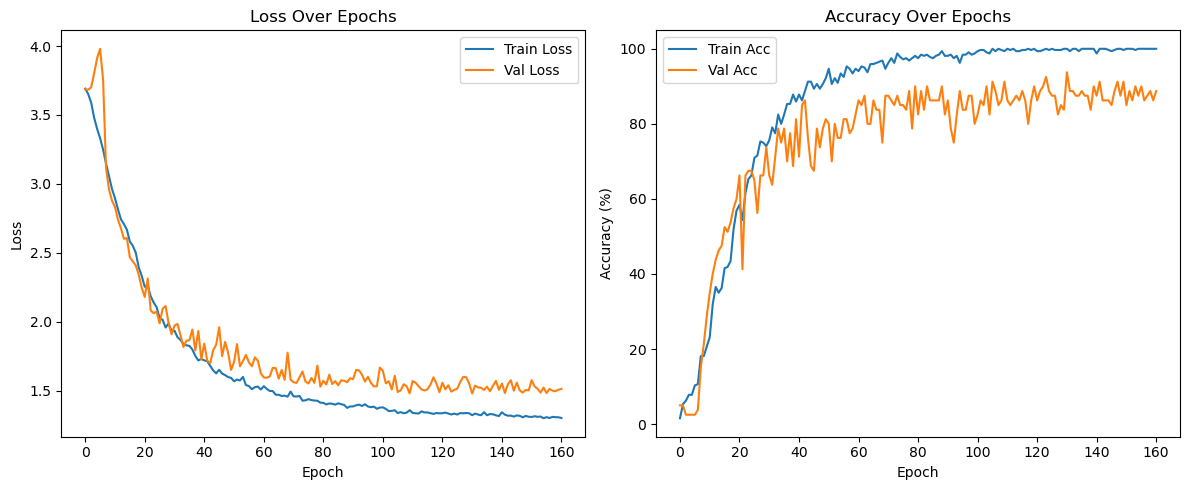

C:\Users\thiru\AppData\Local\Temp\ipykernel_35520\3009100827.py:272: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))



✅ Best Validation Loss: 1.4799
🏁 Final Test Accuracy: 89.50%


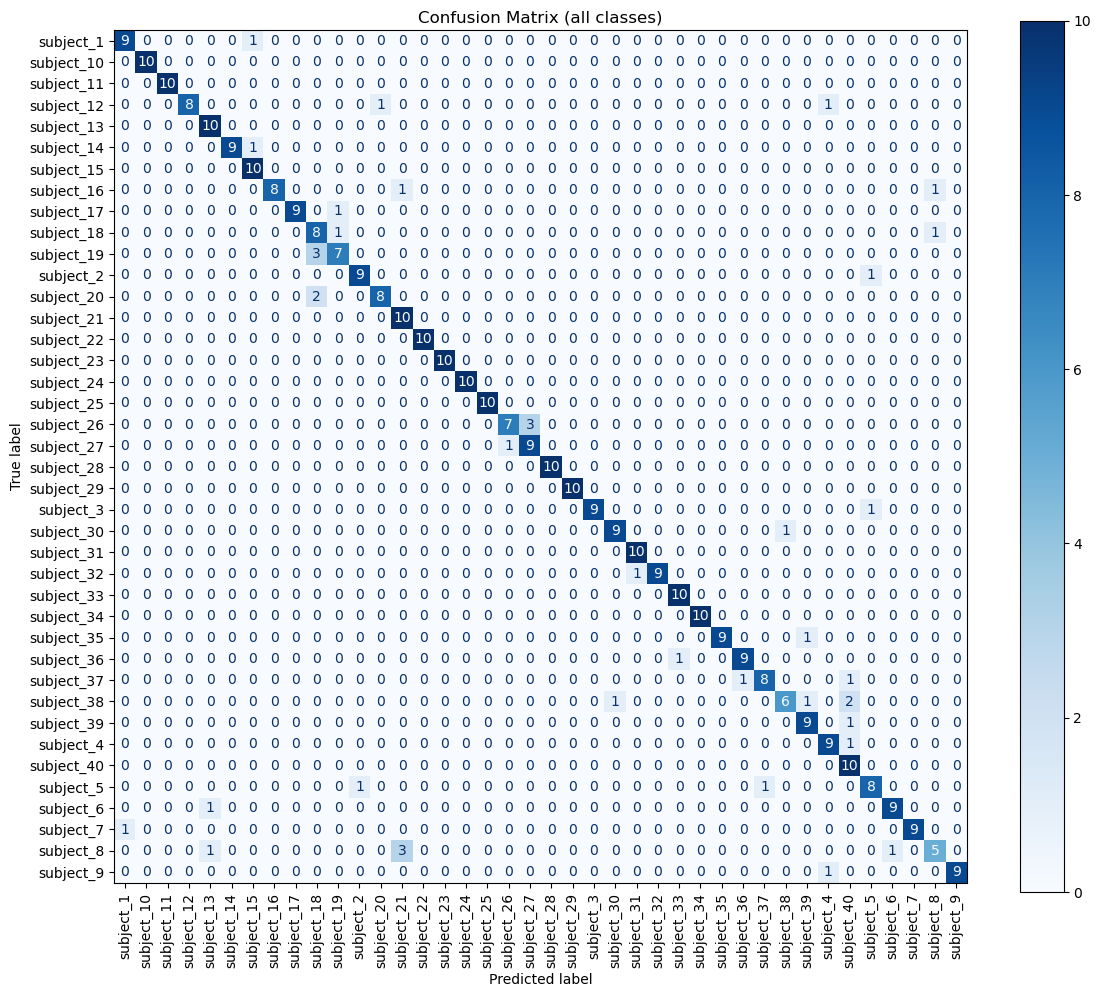


📊 Classification Report:
              precision    recall  f1-score   support

   subject_1       0.90      0.90      0.90        10
  subject_10       1.00      1.00      1.00        10
  subject_11       1.00      1.00      1.00        10
  subject_12       1.00      0.80      0.89        10
  subject_13       0.83      1.00      0.91        10
  subject_14       1.00      0.90      0.95        10
  subject_15       0.83      1.00      0.91        10
  subject_16       1.00      0.80      0.89        10
  subject_17       1.00      0.90      0.95        10
  subject_18       0.62      0.80      0.70        10
  subject_19       0.78      0.70      0.74        10
   subject_2       0.90      0.90      0.90        10
  subject_20       0.89      0.80      0.84        10
  subject_21       0.71      1.00      0.83        10
  subject_22       1.00      1.00      1.00        10
  subject_23       1.00      1.00      1.00        10
  subject_24       1.00      1.00      1.00        10
 

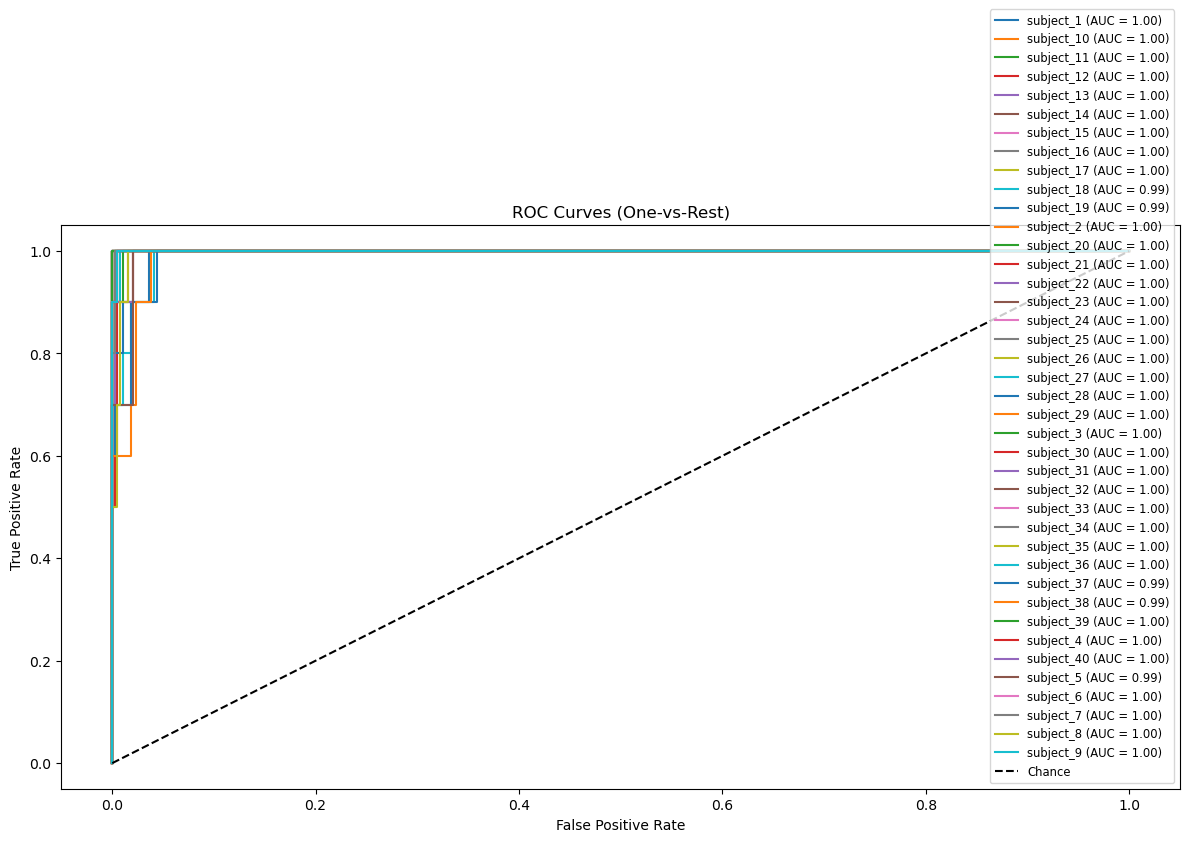

In [316]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi


class GraphVoxelDataset(Dataset):
    def __init__(self, root_dir, grid_size=32, max_points=300, augment=True):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.max_points = max_points
        self.augment = augment
        self.users = sorted([d for d in os.listdir(root_dir)
                             if os.path.isdir(os.path.join(root_dir, d))])
        self.data = self._load_all()

    def _parse_file(self, path):
        pts = []
        with open(path, 'r') as f:
            for line in f:
                parts = re.split(r"[,	 ]+", line.strip())
                if len(parts) < 3:
                    continue
                try:
                    x, y, z = parts[:3]
                    pts.append([float(x), float(y), float(z)])
                except ValueError:
                    continue
        if len(pts) == 0:
            return np.zeros((0, 3))
        return np.array(pts)

    def _voxelize(self, pts):
        if pts.size == 0:
            return np.zeros((self.grid_size,) * 3)
        min_pt, max_pt = pts.min(0), pts.max(0)
        normalized = (pts - min_pt) / (max_pt - min_pt + 1e-8)
        indices = (normalized * (self.grid_size - 1)).astype(int)
        vox = np.zeros((self.grid_size,) * 3)
        for x, y, z in indices:
            vox[x, y, z] += 1
        return np.log1p(vox)

    def _load_all(self):
        train_items, val_items, test_items = [], [], []
        for label, user in enumerate(self.users):
            user_folder = os.path.join(self.root_dir, user)
            for split in ['train', 'test']:
                folder = os.path.join(user_folder, split)
                if not os.path.isdir(folder):
                    continue
                temp = []
                for fn in os.listdir(folder):
                    if not fn.endswith('.txt'):
                        continue
                    path = os.path.join(folder, fn)
                    pts = self._parse_file(path)
                    if pts.shape[0] == 0:
                        continue
                    # pad or truncate
                    pts2 = pts[:self.max_points] if pts.shape[0] >= self.max_points else \
                           np.vstack([pts, np.zeros((self.max_points - pts.shape[0], 3))])
                    vox = self._voxelize(pts)
                    temp.append((torch.FloatTensor(pts2), torch.FloatTensor(vox).unsqueeze(0), label))
                if split == 'train':
                    random.shuffle(temp)
                    cut = int(0.8 * len(temp))
                    train_items.extend(temp[:cut])
                    val_items.extend(temp[cut:])
                else:
                    test_items.extend(temp)
        return [train_items, val_items, test_items]

    def __getitem__(self, idx):
        for subset in self.data:
            if idx < len(subset):
                pts, vox, label = subset[idx]
                if self.augment and random.random() < 0.8:
                    theta = random.uniform(-pi, pi)
                    rot = torch.tensor([
                        [np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta),  np.cos(theta), 0],
                        [0,              0,             1]
                    ], dtype=torch.float32)
                    pts = pts @ rot
                    if random.random() < 0.5:
                        pts += torch.randn_like(pts) * 0.02
                return pts, vox, label
            idx -= len(subset)
        raise IndexError("Index out of range in GraphVoxelDataset")

    def __len__(self):
        return sum(len(subset) for subset in self.data)


class GraphVoxelHybrid(nn.Module):
    def __init__(self, num_classes, d_model=128, k=32):
        super().__init__()
        self.pt_embed = nn.Sequential(
            nn.Linear(3, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.k = k
        self.gcn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.LayerNorm(d_model),
                nn.Dropout(0.2),
                nn.ReLU()
            ) for _ in range(3)
        ])
        self.vx_proj = nn.Sequential(
            nn.Conv3d(1, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(64, d_model, 3, padding=1),
            nn.BatchNorm3d(d_model),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4, 4, 4))
        )
        self.attn_p2v = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.attn_v2p = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.cls = nn.Sequential(
            nn.Linear(d_model * 4, d_model * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model * 2, num_classes)
        )

    def forward(self, pts, vox):
        B, P, _ = pts.size()
        x = self.pt_embed(pts)
        with torch.no_grad():
            dist = torch.cdist(pts, pts)
            knn = dist.topk(self.k + 1, largest=False).indices[:, :, 1:]
            A = torch.zeros(B, P, P, device=pts.device)
            for b in range(B):
                A[b].scatter_(1, knn[b], 1)
            D = A.sum(-1).clamp_min(1)
        for layer in self.gcn_layers:
            x = (A @ x) / D.unsqueeze(-1)
            x = layer(x)
        v = self.vx_proj(vox)
        v = rearrange(v, 'b c d h w -> b (d h w) c')
        p2v, _ = self.attn_p2v(v, x, x)
        v2p, _ = self.attn_v2p(x, v, v)
        p2v_pool = torch.cat([p2v.mean(1), p2v.max(1).values], dim=1)
        v2p_pool = torch.cat([v2p.mean(1), v2p.max(1).values], dim=1)
        feat = torch.cat([p2v_pool, v2p_pool], dim=1)
        return self.cls(feat)


if __name__ == '__main__':
    base_dir = r'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    batch_size = 32
    epochs = 200
    patience = 30

    # Prepare dataset and loaders
    dataset = GraphVoxelDataset(base_dir, augment=True)
    train_ds, val_ds, test_ds = dataset.data
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    # Model, optimizer, etc.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphVoxelHybrid(num_classes=len(dataset.users)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
    # ... rest of code unchanged for brevity ...
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = train_correct = train_total = 0
        for pts, vox, labels in train_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pts, vox)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)
        train_acc = 100.0 * train_correct / train_total
        train_loss /= train_total

        model.eval()
        val_loss = val_correct = val_total = 0
        with torch.no_grad():
            for pts, vox, labels in val_loader:
                pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
                outputs = model(pts, vox)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_acc = 100.0 * val_correct / val_total
        val_loss /= val_total

        scheduler.step(val_loss)
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.2e}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\n⏹️ No improvement in {patience} epochs. Early stopping...")
                break

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    test_correct = test_total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for pts, vox, labels in test_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            outputs = model(pts, vox)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    final_test_acc = 100.0 * test_correct / test_total

    print(f"\n✅ Best Validation Loss: {best_val_loss:.4f}")
    print(f"🏁 Final Test Accuracy: {final_test_acc:.2f}%")

    # Confusion matrix (all classes)
    labels_list = list(range(len(dataset.users)))
    cm = confusion_matrix(all_labels, all_preds, labels=labels_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.users)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix (all classes)")
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(
        all_labels, all_preds,
        labels=labels_list,
        target_names=dataset.users
    ))

    # ROC and AUC curves (one-vs-rest)
    y_true = np.array(all_labels)
    y_pred_probs = []
    with torch.no_grad():
        for pts, vox, _ in test_loader:
            pts, vox = pts.to(device), vox.to(device)
            outputs = model(pts, vox)
            probs = torch.softmax(outputs, dim=1)
            y_pred_probs.extend(probs.cpu().numpy())
    y_score = np.array(y_pred_probs)
    n_classes = len(dataset.users)
    y_bin = np.zeros((len(y_true), n_classes))
    for i, label in enumerate(y_true):
        y_bin[i, label] = 1

    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{dataset.users[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', fontsize='small')
    plt.tight_layout()
    plt.show()

Detected 35 users (classes), after excluding: {'subject_5', 'subject_26', 'subject_18', 'subject_25', 'subject_21'}
Epoch 001 | Train Loss: 3.5689 | Train Acc: 3.21% | Val Loss: 3.5457 | Val Acc: 2.86% | LR: 3.00e-04
Epoch 002 | Train Loss: 3.4135 | Train Acc: 7.14% | Val Loss: 3.7069 | Val Acc: 2.86% | LR: 3.00e-04
Epoch 003 | Train Loss: 3.2397 | Train Acc: 7.50% | Val Loss: 4.0681 | Val Acc: 2.86% | LR: 3.00e-04
Epoch 004 | Train Loss: 3.0974 | Train Acc: 12.50% | Val Loss: 5.0248 | Val Acc: 2.86% | LR: 3.00e-04
Epoch 005 | Train Loss: 2.9867 | Train Acc: 18.93% | Val Loss: 4.9273 | Val Acc: 2.86% | LR: 3.00e-04
Epoch 006 | Train Loss: 2.7039 | Train Acc: 23.21% | Val Loss: 4.7482 | Val Acc: 2.86% | LR: 3.00e-04
Epoch 007 | Train Loss: 2.6037 | Train Acc: 30.36% | Val Loss: 4.3471 | Val Acc: 2.86% | LR: 3.00e-04
Epoch 008 | Train Loss: 2.4876 | Train Acc: 33.21% | Val Loss: 3.4454 | Val Acc: 8.57% | LR: 3.00e-04
Epoch 009 | Train Loss: 2.2856 | Train Acc: 43.93% | Val Loss: 2.1886 |

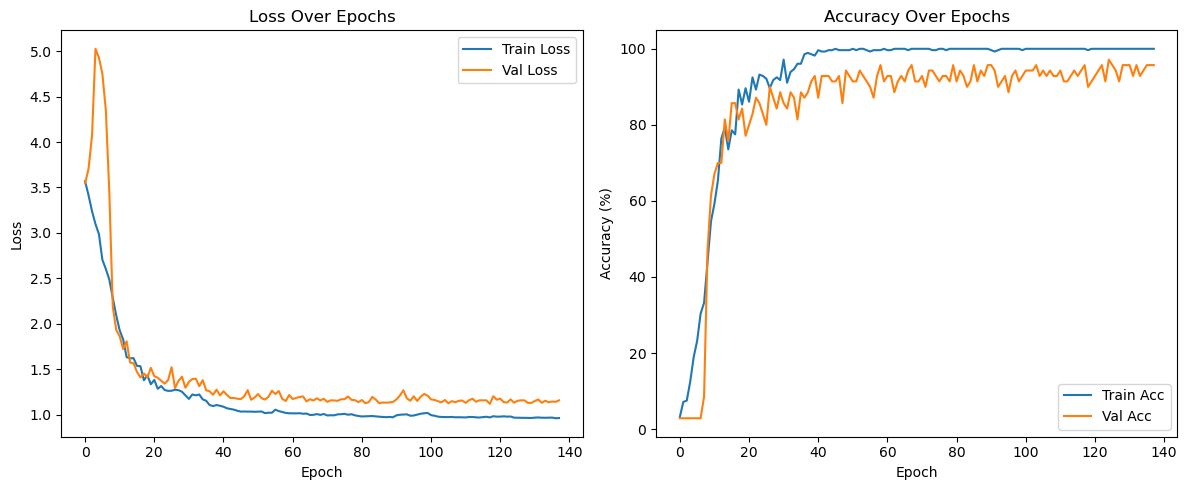

C:\Users\thiru\AppData\Local\Temp\ipykernel_35520\233952892.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))



✅ Best Validation Loss: 1.1213
🏁 Final Test Accuracy: 95.14%


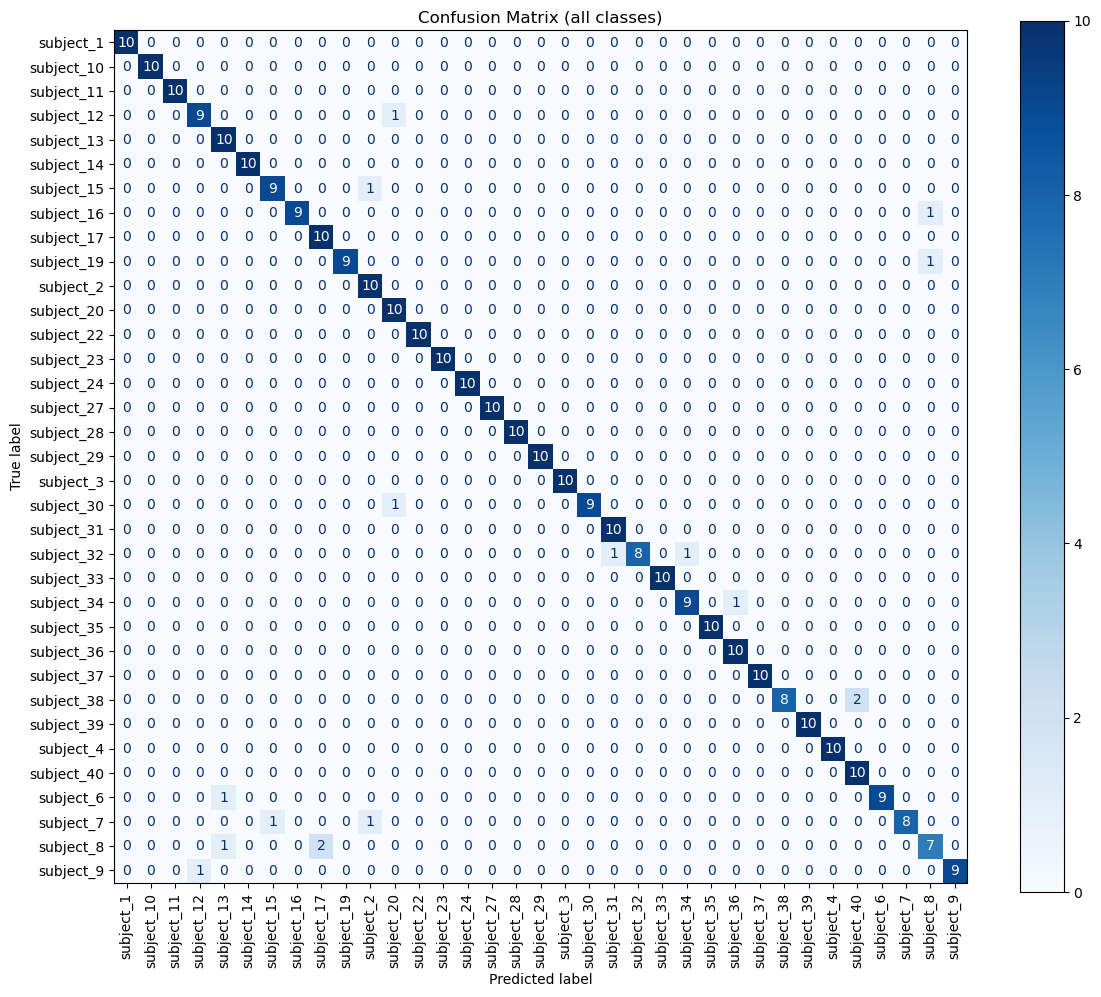


📊 Classification Report:
              precision    recall  f1-score   support

   subject_1       1.00      1.00      1.00        10
  subject_10       1.00      1.00      1.00        10
  subject_11       1.00      1.00      1.00        10
  subject_12       0.90      0.90      0.90        10
  subject_13       0.83      1.00      0.91        10
  subject_14       1.00      1.00      1.00        10
  subject_15       0.90      0.90      0.90        10
  subject_16       1.00      0.90      0.95        10
  subject_17       0.83      1.00      0.91        10
  subject_19       1.00      0.90      0.95        10
   subject_2       0.83      1.00      0.91        10
  subject_20       0.83      1.00      0.91        10
  subject_22       1.00      1.00      1.00        10
  subject_23       1.00      1.00      1.00        10
  subject_24       1.00      1.00      1.00        10
  subject_27       1.00      1.00      1.00        10
  subject_28       1.00      1.00      1.00        10
 

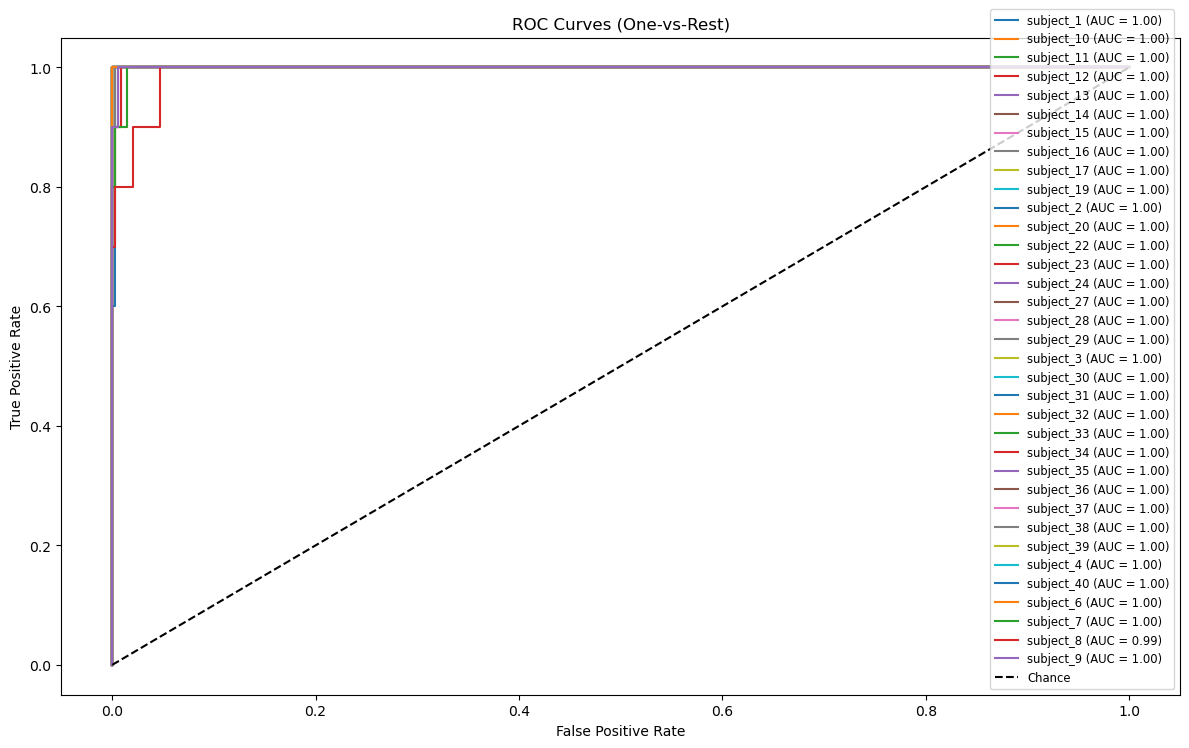

In [99]:

import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# List classes to exclude
EXCLUDED_USERS = {'subject_18', 'subject_21', 'subject_25', 'subject_26', 'subject_5'}

class GraphVoxelDataset(Dataset):
    def __init__(self, root_dir, grid_size=32, max_points=300, augment=True):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.max_points = max_points
        self.augment = augment
        # Load user folders, excluding specified classes
        all_users = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d)) and d not in EXCLUDED_USERS
        ])
        self.users = all_users
        self.label_map = {user: idx for idx, user in enumerate(self.users)
        self.data = self._load_all()

    def _parse_file(self, path):
        pts = []
        with open(path, 'r') as f:
            for line in f:
                parts = re.split(r"[,	 ]+", line.strip())
                if len(parts) < 3:
                    continue
                try:
                    x, y, z = parts[:3]
                    pts.append([float(x), float(y), float(z)])
                except ValueError:
                    continue
        if len(pts) == 0:
            return np.zeros((0, 3))
        return np.array(pts)

    def _voxelize(self, pts):
        if pts.size == 0:
            return np.zeros((self.grid_size,) * 3)
        min_pt, max_pt = pts.min(0), pts.max(0)
        normalized = (pts - min_pt) / (max_pt - min_pt + 1e-8)
        indices = (normalized * (self.grid_size - 1)).astype(int)
        vox = np.zeros((self.grid_size,) * 3)
        for x, y, z in indices:
            vox[x, y, z] += 1
        return np.log1p(vox)

    def _load_all(self):
        train_items, val_items, test_items = [], [], []
        for user in self.users:
            label = self.label_map[user]
            for split in ['train', 'test']:
                folder = os.path.join(self.root_dir, user, split)
                if not os.path.isdir(folder):
                    print(f"Warning: Missing {split} folder for user {user}")
                    continue
                temp = []
                for fn in os.listdir(folder):
                    if not fn.lower().endswith('.txt'):
                        continue
                    path = os.path.join(folder, fn)
                    pts = self._parse_file(path)
                    if pts.shape[0] == 0:
                        print(f"Warning: No valid points parsed in {path}")
                        continue
                    pts2 = pts[:self.max_points] if pts.shape[0] >= self.max_points else np.vstack([
                        pts, np.zeros((self.max_points - pts.shape[0], 3))
                    ])
                    vox = self._voxelize(pts)
                    temp.append((torch.FloatTensor(pts2), torch.FloatTensor(vox).unsqueeze(0), label))
                if split == 'train':
                    if len(temp) == 0:
                        print(f"Warning: No training samples for user {user}")
                    random.shuffle(temp)
                    cut = int(0.8 * len(temp))
                    train_items.extend(temp[:cut])
                    val_items.extend(temp[cut:])
                else:
                    if len(temp) == 0:
                        print(f"Warning: No test samples for user {user}")
                    test_items.extend(temp)
        return [train_items, val_items, test_items]

    def __getitem__(self, idx):
        for subset in self.data:
            if idx < len(subset):
                pts, vox, label = subset[idx]
                if self.augment and random.random() < 0.8:
                    theta = random.uniform(-pi, pi)
                    rot = torch.tensor([
                        [np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta),  np.cos(theta), 0],
                        [0,              0,             1]
                    ], dtype=torch.float32)
                    pts = pts @ rot
                    if random.random() < 0.5:
                        pts += torch.randn_like(pts) * 0.02
                return pts, vox, label
            idx -= len(subset)
        raise IndexError("Index out of range in GraphVoxelDataset")

    def __len__(self):
        return sum(len(subset) for subset in self.data)


class GraphVoxelHybrid(nn.Module):
    def __init__(self, num_classes, d_model=512, k=32):
        super().__init__()
        self.pt_embed = nn.Sequential(
            nn.Linear(3, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.k = k
        self.gcn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.LayerNorm(d_model),
                nn.Dropout(0.3),
                nn.ReLU()
            ) for _ in range(3)
        ])
        self.vx_proj = nn.Sequential(
            nn.Conv3d(1, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(64, d_model, 3, padding=1),
            nn.BatchNorm3d(d_model),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4, 4, 4))
        )
        self.attn_p2v = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.attn_v2p = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.cls = nn.Sequential(
            nn.Linear(d_model * 4, d_model * 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(d_model * 2, num_classes)
        )

    def forward(self, pts, vox):
        B, P, _ = pts.size()
        x = self.pt_embed(pts)
        with torch.no_grad():
            dist = torch.cdist(pts, pts)
            knn = dist.topk(self.k + 1, largest=False).indices[:, :, 1:]
            A = torch.zeros(B, P, P, device=pts.device)
            for b in range(B):
                A[b].scatter_(1, knn[b], 1)
            D = A.sum(-1).clamp_min(1)
        for layer in self.gcn_layers:
            x = (A @ x) / D.unsqueeze(-1)
            x = layer(x)
        v = self.vx_proj(vox)
        v = rearrange(v, 'b c d h w -> b (d h w) c')
        p2v, _ = self.attn_p2v(v, x, x)
        v2p, _ = self.attn_v2p(x, v, v)
        p2v_pool = torch.cat([p2v.mean(1), p2v.max(1).values], dim=1)
        v2p_pool = torch.cat([v2p.mean(1), v2p.max(1).values], dim=1)
        feat = torch.cat([p2v_pool, v2p_pool], dim=1)
        return self.cls(feat)


if __name__ == '__main__':
    base_dir = r'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    batch_size = 32
    epochs = 200
    patience = 20

    dataset = GraphVoxelDataset(base_dir, augment=True)
    print(f"Detected {len(dataset.users)} users (classes), after excluding: {EXCLUDED_USERS}")
    train_ds, val_ds, test_ds = dataset.data
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphVoxelHybrid(num_classes=len(dataset.users)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15)

    # ... rest of code unchanged for brevity ...
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = train_correct = train_total = 0
        for pts, vox, labels in train_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pts, vox)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)
        train_acc = 100.0 * train_correct / train_total
        train_loss /= train_total

        model.eval()
        val_loss = val_correct = val_total = 0
        with torch.no_grad():
            for pts, vox, labels in val_loader:
                pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
                outputs = model(pts, vox)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_acc = 100.0 * val_correct / val_total
        val_loss /= val_total

        scheduler.step(val_loss)
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.2e}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\n⏹️ No improvement in {patience} epochs. Early stopping...")
                break

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    test_correct = test_total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for pts, vox, labels in test_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            outputs = model(pts, vox)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    final_test_acc = 100.0 * test_correct / test_total

    print(f"\n✅ Best Validation Loss: {best_val_loss:.4f}")
    print(f"🏁 Final Test Accuracy: {final_test_acc:.2f}%")

    # Confusion matrix (all classes)
    labels_list = list(range(len(dataset.users)))
    cm = confusion_matrix(all_labels, all_preds, labels=labels_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.users)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix (all classes)")
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(
        all_labels, all_preds,
        labels=labels_list,
        target_names=dataset.users
    ))

    # ROC and AUC curves (one-vs-rest)
    y_true = np.array(all_labels)
    y_pred_probs = []
    with torch.no_grad():
        for pts, vox, _ in test_loader:
            pts, vox = pts.to(device), vox.to(device)
            outputs = model(pts, vox)
            probs = torch.softmax(outputs, dim=1)
            y_pred_probs.extend(probs.cpu().numpy())
    y_score = np.array(y_pred_probs)
    n_classes = len(dataset.users)
    y_bin = np.zeros((len(y_true), n_classes))
    for i, label in enumerate(y_true):
        y_bin[i, label] = 1

    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{dataset.users[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', fontsize='small')
    plt.tight_layout()
    plt.show()


In [230]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi


class GraphVoxelDataset(Dataset):
    def __init__(self, root_dir, grid_size=32, max_points=300, augment=True):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.max_points = max_points
        self.augment = augment
        self.users = sorted([d for d in os.listdir(root_dir)
                             if os.path.isdir(os.path.join(root_dir, d))])
        self.data = self._load_all()

    def _parse_file(self, path):
        pts = []
        with open(path, 'r') as f:
            for line in f:
                parts = re.split(r"[,	 ]+", line.strip())
                if len(parts) < 3:
                    continue
                try:
                    x, y, z = parts[:3]
                    pts.append([float(x), float(y), float(z)])
                except ValueError:
                    continue
        if len(pts) == 0:
            return np.zeros((0, 3))
        return np.array(pts)

    def _voxelize(self, pts):
        if pts.size == 0:
            return np.zeros((self.grid_size,) * 3)
        min_pt, max_pt = pts.min(0), pts.max(0)
        normalized = (pts - min_pt) / (max_pt - min_pt + 1e-8)
        indices = (normalized * (self.grid_size - 1)).astype(int)
        vox = np.zeros((self.grid_size,) * 3)
        for x, y, z in indices:
            vox[x, y, z] += 1
        return np.log1p(vox)

    def _load_all(self):
        train_items, val_items, test_items = [], [], []
        for label, user in enumerate(self.users):
            user_folder = os.path.join(self.root_dir, user)
            for split in ['train', 'test']:
                folder = os.path.join(user_folder, split)
                if not os.path.isdir(folder):
                    continue
                temp = []
                for fn in os.listdir(folder):
                    if not fn.endswith('.txt'):
                        continue
                    path = os.path.join(folder, fn)
                    pts = self._parse_file(path)
                    if pts.shape[0] == 0:
                        continue
                    # pad or truncate
                    pts2 = pts[:self.max_points] if pts.shape[0] >= self.max_points else \
                           np.vstack([pts, np.zeros((self.max_points - pts.shape[0], 3))])
                    vox = self._voxelize(pts)
                    temp.append((torch.FloatTensor(pts2), torch.FloatTensor(vox).unsqueeze(0), label))
                if split == 'train':
                    random.shuffle(temp)
                    cut = int(0.8 * len(temp))
                    train_items.extend(temp[:cut])
                    val_items.extend(temp[cut:])
                else:
                    test_items.extend(temp)
        return [train_items, val_items, test_items]
    def __getitem__(self, idx):
        for subset in self.data:
            if idx < len(subset):
                pts, vox, label = subset[idx]
                if self.augment and random.random() < 0.8:
                    theta = random.uniform(-pi, pi)
                    rot = torch.tensor([
                        [np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta),  np.cos(theta), 0],
                        [0,              0,             1]
                    ], dtype=torch.float32)
                    pts = pts @ rot
                    
                    # Enhanced augmentations
                    scale = torch.FloatTensor(3).uniform_(0.9, 1.1)
                    pts *= scale
                    
                    if random.random() < 0.8:
                        pts += torch.randn_like(pts) * 0.05
                        
                    if random.random() < 0.3:
                        mask = torch.rand(pts.size(0)) < 0.2
                        pts[mask] = 0
                return pts, vox, label
            idx -= len(subset)
        raise IndexError("Index out of range in GraphVoxelDataset")

    def __len__(self):
        return sum(len(subset) for subset in self.data)


class GraphVoxelHybrid(nn.Module):
    def __init__(self, num_classes, d_model=512, k=32):
        super().__init__()
        self.pt_embed = nn.Sequential(
            nn.Linear(3, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU()
            # nn.Dropout(0.2)
        )
        self.k = k
        self.gcn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.LayerNorm(d_model),
                # nn.Dropout(0.2)
                nn.ReLU()
            ) for _ in range(5)
        ])
        self.vx_proj = nn.Sequential(
            nn.Conv3d(1, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(1),
            nn.Conv3d(64, d_model, 2, padding=1),
            nn.BatchNorm3d(d_model),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4, 4, 4))
        )
        self.attn_p2v = nn.MultiheadAttention(d_model, num_heads=16, batch_first=True)
        self.attn_v2p = nn.MultiheadAttention(d_model, num_heads=16, batch_first=True)
        self.cls = nn.Sequential(
            nn.Linear(d_model * 4, d_model * 2),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(d_model * 2, num_classes)
        )

    def forward(self, pts, vox):
        B, P, _ = pts.size()
        x = self.pt_embed(pts)
        with torch.no_grad():
            dist = torch.cdist(pts, pts)
            knn = dist.topk(self.k + 1, largest=False).indices[:, :, 1:]
            A = torch.zeros(B, P, P, device=pts.device)
            for b in range(B):
                A[b].scatter_(1, knn[b], 1)
            D = A.sum(-1).clamp_min(1)
        for layer in self.gcn_layers:
            x = (A @ x) / D.unsqueeze(-1)
            x = layer(x)
        v = self.vx_proj(vox)
        v = rearrange(v, 'b c d h w -> b (d h w) c')
        p2v, _ = self.attn_p2v(v, x, x)
        v2p, _ = self.attn_v2p(x, v, v)
        p2v_pool = torch.cat([p2v.mean(1), p2v.max(1).values], dim=1)
        v2p_pool = torch.cat([v2p.mean(1), v2p.max(1).values], dim=1)
        feat = torch.cat([p2v_pool, v2p_pool], dim=1)
        return self.cls(feat)


if __name__ == '__main__':
    base_dir = r'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    batch_size = 16
    epochs = 200
    patience = 30

    # Prepare dataset and loaders
    dataset = GraphVoxelDataset(base_dir, augment=True)
    train_ds, val_ds, test_ds = dataset.data
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    # Model, optimizer, etc.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphVoxelHybrid(num_classes=len(dataset.users)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.5e-1)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=0, factor=0.2)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    # ... rest of code unchanged for brevity ...
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = train_correct = train_total = 0
        for pts, vox, labels in train_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pts, vox)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)
        train_acc = 100.0 * train_correct / train_total
        train_loss /= train_total

        model.eval()
        val_loss = val_correct = val_total = 0
        with torch.no_grad():
            for pts, vox, labels in val_loader:
                pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
                outputs = model(pts, vox)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_acc = 100.0 * val_correct / val_total
        val_loss /= val_total

        scheduler.step(val_loss)
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.2e}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\n⏹️ No improvement in {patience} epochs. Early stopping...")
                break

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    test_correct = test_total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for pts, vox, labels in test_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            outputs = model(pts, vox)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    final_test_acc = 100.0 * test_correct / test_total

    print(f"\n✅ Best Validation Loss: {best_val_loss:.4f}")
    print(f"🏁 Final Test Accuracy: {final_test_acc:.2f}%")

    # Confusion matrix (all classes)
    labels_list = list(range(len(dataset.users)))
    cm = confusion_matrix(all_labels, all_preds, labels=labels_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.users)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix (all classes)")
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(
        all_labels, all_preds,
        labels=labels_list,
        target_names=dataset.users
    ))

    # ROC and AUC curves (one-vs-rest)
    y_true = np.array(all_labels)
    y_pred_probs = []
    with torch.no_grad():
        for pts, vox, _ in test_loader:
            pts, vox = pts.to(device), vox.to(device)
            outputs = model(pts, vox)
            probs = torch.softmax(outputs, dim=1)
            y_pred_probs.extend(probs.cpu().numpy())
    y_score = np.array(y_pred_probs)
    n_classes = len(dataset.users)
    y_bin = np.zeros((len(y_true), n_classes))
    for i, label in enumerate(y_true):
        y_bin[i, label] = 1

    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{dataset.users[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', fontsize='small')
    plt.tight_layout()
    plt.show()

Epoch 001 | Train Loss: 3.7003 | Train Acc: 2.19% | Val Loss: 3.6796 | Val Acc: 2.50% | LR: 3.00e-05
Epoch 002 | Train Loss: 3.6644 | Train Acc: 4.38% | Val Loss: 3.6599 | Val Acc: 7.50% | LR: 3.00e-05
Epoch 003 | Train Loss: 3.6059 | Train Acc: 5.31% | Val Loss: 3.6083 | Val Acc: 5.00% | LR: 3.00e-05
Epoch 004 | Train Loss: 3.5000 | Train Acc: 5.62% | Val Loss: 3.4176 | Val Acc: 10.00% | LR: 3.00e-05
Epoch 005 | Train Loss: 3.3552 | Train Acc: 6.56% | Val Loss: 3.2441 | Val Acc: 12.50% | LR: 3.00e-05
Epoch 006 | Train Loss: 3.2069 | Train Acc: 8.44% | Val Loss: 3.0952 | Val Acc: 10.00% | LR: 3.00e-05


KeyboardInterrupt: 

Epoch 001 | Train Loss: 3.6882 | Train Acc: 2.50% | Val Loss: 3.6862 | Val Acc: 2.50% | LR: 3.00e-04
Epoch 002 | Train Loss: 3.6115 | Train Acc: 5.00% | Val Loss: 3.7327 | Val Acc: 2.50% | LR: 3.00e-04
Epoch 003 | Train Loss: 3.5408 | Train Acc: 5.94% | Val Loss: 3.9323 | Val Acc: 2.50% | LR: 3.00e-04
Epoch 004 | Train Loss: 3.4826 | Train Acc: 9.38% | Val Loss: 3.9523 | Val Acc: 3.75% | LR: 3.00e-04
Epoch 005 | Train Loss: 3.4436 | Train Acc: 11.56% | Val Loss: 3.9923 | Val Acc: 2.50% | LR: 3.00e-04
Epoch 006 | Train Loss: 3.3657 | Train Acc: 16.25% | Val Loss: 3.9473 | Val Acc: 2.50% | LR: 3.00e-04
Epoch 007 | Train Loss: 3.3027 | Train Acc: 20.00% | Val Loss: 3.4237 | Val Acc: 11.25% | LR: 3.00e-04
Epoch 008 | Train Loss: 3.2361 | Train Acc: 27.50% | Val Loss: 3.2430 | Val Acc: 26.25% | LR: 3.00e-04
Epoch 009 | Train Loss: 3.1965 | Train Acc: 27.81% | Val Loss: 3.1542 | Val Acc: 26.25% | LR: 3.00e-04
Epoch 010 | Train Loss: 3.1570 | Train Acc: 27.81% | Val Loss: 3.0442 | Val Acc: 45

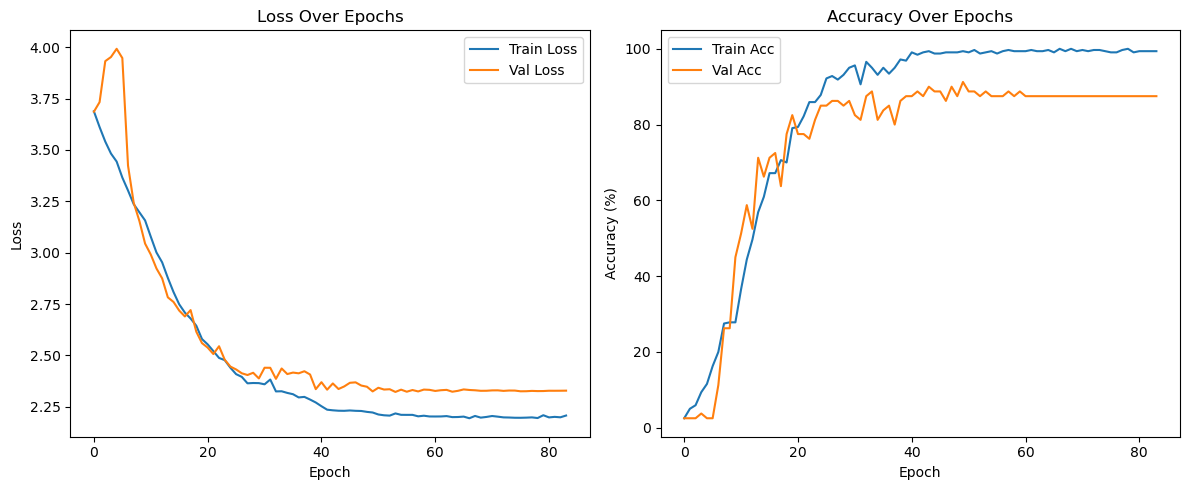

C:\Users\thiru\AppData\Local\Temp\ipykernel_35520\1203439992.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))



✅ Best Validation Loss: 2.3222
🏁 Final Test Accuracy: 90.50%


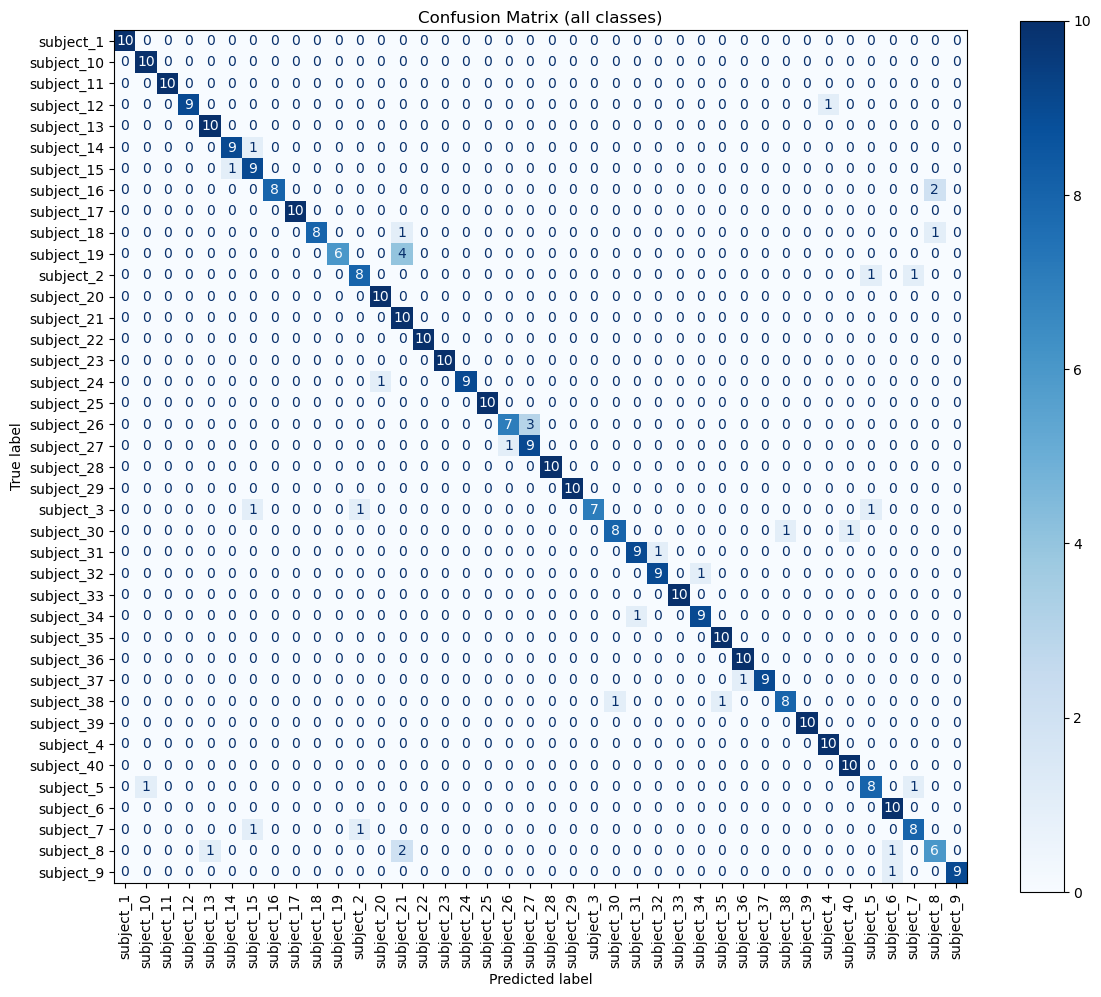


📊 Classification Report:
              precision    recall  f1-score   support

   subject_1       1.00      1.00      1.00        10
  subject_10       0.91      1.00      0.95        10
  subject_11       1.00      1.00      1.00        10
  subject_12       1.00      0.90      0.95        10
  subject_13       0.91      1.00      0.95        10
  subject_14       0.90      0.90      0.90        10
  subject_15       0.75      0.90      0.82        10
  subject_16       1.00      0.80      0.89        10
  subject_17       1.00      1.00      1.00        10
  subject_18       1.00      0.80      0.89        10
  subject_19       1.00      0.60      0.75        10
   subject_2       0.80      0.80      0.80        10
  subject_20       0.91      1.00      0.95        10
  subject_21       0.59      1.00      0.74        10
  subject_22       1.00      1.00      1.00        10
  subject_23       1.00      1.00      1.00        10
  subject_24       1.00      0.90      0.95        10
 

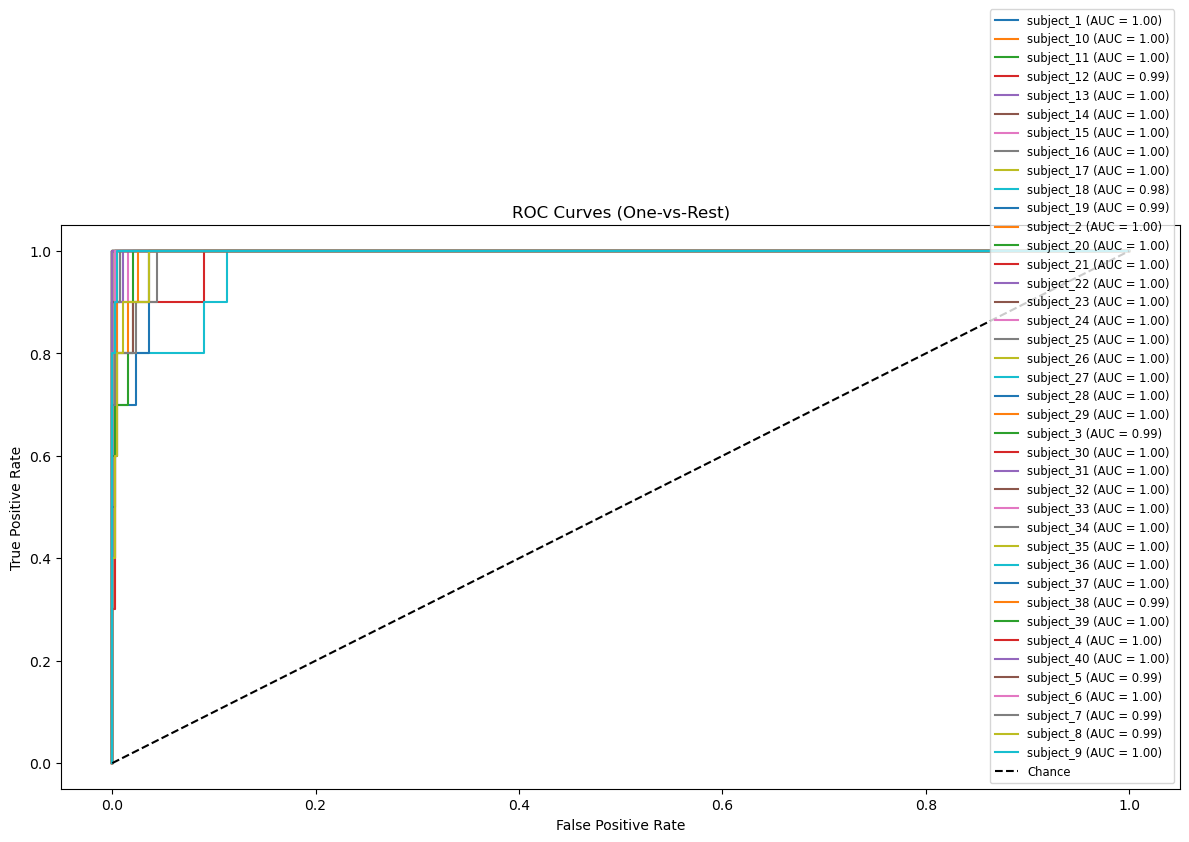

In [278]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi

from tensorflow.keras.callbacks import ReduceLROnPlateau

class GraphVoxelDataset(Dataset):
    def __init__(self, root_dir, grid_size=32, max_points=300, augment=True):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.max_points = max_points
        self.augment = augment
        self.users = sorted([d for d in os.listdir(root_dir)
                             if os.path.isdir(os.path.join(root_dir, d))])
        self.data = self._load_all()

    def _parse_file(self, path):
        pts = []
        with open(path, 'r') as f:
            for line in f:
                parts = re.split(r"[,	 ]+", line.strip())
                if len(parts) < 3:
                    continue
                try:
                    x, y, z = parts[:3]
                    pts.append([float(x), float(y), float(z)])
                except ValueError:
                    continue
        if len(pts) == 0:
            return np.zeros((0, 3))
        return np.array(pts)

    def _voxelize(self, pts):
        if pts.size == 0:
            return np.zeros((self.grid_size,) * 3)
        min_pt, max_pt = pts.min(0), pts.max(0)
        normalized = (pts - min_pt) / (max_pt - min_pt + 1e-8)
        indices = (normalized * (self.grid_size - 1)).astype(int)
        vox = np.zeros((self.grid_size,) * 3)
        for x, y, z in indices:
            vox[x, y, z] += 1
        return np.log1p(vox)

    def _load_all(self):
        train_items, val_items, test_items = [], [], []
        for label, user in enumerate(self.users):
            user_folder = os.path.join(self.root_dir, user)
            for split in ['train', 'test']:
                folder = os.path.join(user_folder, split)
                if not os.path.isdir(folder):
                    continue
                temp = []
                for fn in os.listdir(folder):
                    if not fn.endswith('.txt'):
                        continue
                    path = os.path.join(folder, fn)
                    pts = self._parse_file(path)
                    if pts.shape[0] == 0:
                        continue
                    # pad or truncate
                    pts2 = pts[:self.max_points] if pts.shape[0] >= self.max_points else \
                           np.vstack([pts, np.zeros((self.max_points - pts.shape[0], 3))])
                    vox = self._voxelize(pts)
                    temp.append((torch.FloatTensor(pts2), torch.FloatTensor(vox).unsqueeze(0), label))
                if split == 'train':
                    random.shuffle(temp)
                    cut = int(0.8 * len(temp))
                    train_items.extend(temp[:cut])
                    val_items.extend(temp[cut:])
                else:
                    test_items.extend(temp)
        return [train_items, val_items, test_items]

    def __getitem__(self, idx):
        for subset in self.data:
            if idx < len(subset):
                pts, vox, label = subset[idx]
                if self.augment and random.random() < 0.8:
                    theta = random.uniform(-pi, pi)
                    rot = torch.tensor([
                        [np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta),  np.cos(theta), 0],
                        [0,              0,             1]
                    ], dtype=torch.float32)
                    pts = pts @ rot
                    if random.random() < 0.5:
                        pts += torch.randn_like(pts) * 0.02
                return pts, vox, label
            idx -= len(subset)
        raise IndexError("Index out of range in GraphVoxelDataset")

    def __len__(self):
        return sum(len(subset) for subset in self.data)


class GraphVoxelHybrid(nn.Module):
    def __init__(self, num_classes, d_model=256, k=32):
        super().__init__()
        self.pt_embed = nn.Sequential(
            nn.Linear(3, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.k = k
        self.gcn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.LayerNorm(d_model),
                nn.Dropout(0.2),
                nn.ReLU()
            ) for _ in range(4)
        ])
        self.vx_proj = nn.Sequential(
            nn.Conv3d(1, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(64, d_model, 3, padding=1),
            nn.BatchNorm3d(d_model),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4, 4, 4))
        )
        self.attn_p2v = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.attn_v2p = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.cls = nn.Sequential(
            nn.Linear(d_model * 4, d_model * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model * 2, num_classes)
        )

    def forward(self, pts, vox):
        B, P, _ = pts.size()
        x = self.pt_embed(pts)
        with torch.no_grad():
            dist = torch.cdist(pts, pts)
            knn = dist.topk(self.k + 1, largest=False).indices[:, :, 1:]
            A = torch.zeros(B, P, P, device=pts.device)
            for b in range(B):
                A[b].scatter_(1, knn[b], 1)
            D = A.sum(-1).clamp_min(1)
        for layer in self.gcn_layers:
            x = (A @ x) / D.unsqueeze(-1)
            x = layer(x)
        v = self.vx_proj(vox)
        v = rearrange(v, 'b c d h w -> b (d h w) c')
        p2v, _ = self.attn_p2v(v, x, x)
        v2p, _ = self.attn_v2p(x, v, v)
        p2v_pool = torch.cat([p2v.mean(1), p2v.max(1).values], dim=1)
        v2p_pool = torch.cat([v2p.mean(1), v2p.max(1).values], dim=1)
        feat = torch.cat([p2v_pool, v2p_pool], dim=1)
        return self.cls(feat)


if __name__ == '__main__':
    base_dir = r'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
    batch_size = 32
    epochs = 300
    patience = 30

    # Prepare dataset and loaders
    dataset = GraphVoxelDataset(base_dir, augment=True)
    train_ds, val_ds, test_ds = dataset.data
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    # Model, optimizer, etc.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphVoxelHybrid(num_classes=len(dataset.users)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.003)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.4)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.4)
    # ... rest of code unchanged for brevity ...
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = train_correct = train_total = 0
        for pts, vox, labels in train_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pts, vox)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)
        train_acc = 100.0 * train_correct / train_total
        train_loss /= train_total

        model.eval()
        val_loss = val_correct = val_total = 0
        with torch.no_grad():
            for pts, vox, labels in val_loader:
                pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
                outputs = model(pts, vox)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_acc = 100.0 * val_correct / val_total
        val_loss /= val_total

        scheduler.step(val_loss)
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.2e}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\n⏹️ No improvement in {patience} epochs. Early stopping...")
                break

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    test_correct = test_total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for pts, vox, labels in test_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            outputs = model(pts, vox)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    final_test_acc = 100.0 * test_correct / test_total

    print(f"\n✅ Best Validation Loss: {best_val_loss:.4f}")
    print(f"🏁 Final Test Accuracy: {final_test_acc:.2f}%")

    # Confusion matrix (all classes)
    labels_list = list(range(len(dataset.users)))
    cm = confusion_matrix(all_labels, all_preds, labels=labels_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.users)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix (all classes)")
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(
        all_labels, all_preds,
        labels=labels_list,
        target_names=dataset.users
    ))

    # ROC and AUC curves (one-vs-rest)
    y_true = np.array(all_labels)
    y_pred_probs = []
    with torch.no_grad():
        for pts, vox, _ in test_loader:
            pts, vox = pts.to(device), vox.to(device)
            outputs = model(pts, vox)
            probs = torch.softmax(outputs, dim=1)
            y_pred_probs.extend(probs.cpu().numpy())
    y_score = np.array(y_pred_probs)
    n_classes = len(dataset.users)
    y_bin = np.zeros((len(y_true), n_classes))
    for i, label in enumerate(y_true):
        y_bin[i, label] = 1

    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{dataset.users[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', fontsize='small')
    plt.tight_layout()
    plt.show()

In [318]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay

# ----------------------------
# 1) Dataset
# ----------------------------
class GraphVoxelDataset(Dataset):
    def __init__(self, root_dir, split='train', grid_size=32, max_points=300, augment=True):
        """
        Args:
            root_dir (str): Path to DeepAirSig_Dataset folder
            split (str): 'train', 'val', or 'test'
            grid_size (int): voxel grid resolution
            max_points (int): number of points to pad/truncate to
            augment (bool): apply augmentation on train only
        """
        assert split in ('train', 'val', 'test')
        self.root_dir = root_dir
        self.split = split
        self.grid_size = grid_size
        self.max_points = max_points
        self.augment = augment

        self.samples = []  # list of (filepath, label)

        # 1a) genuine: train/val from Genuine/<subject>/train or test
        genuine_root = os.path.join(root_dir, 'Genuine')
        for subj in sorted(os.listdir(genuine_root)):
            subj_dir = os.path.join(genuine_root, subj)
            if not os.path.isdir(subj_dir):
                continue
            if split in ('train', 'val'):
                subfolder = 'train' if split == 'train' else 'test'
                folder = os.path.join(subj_dir, subfolder)
                if os.path.isdir(folder):
                    for fn in os.listdir(folder):
                        if fn.endswith('.txt'):
                            self.samples.append((os.path.join(folder, fn), 1))
            else:  # test
                # include genuine/test
                folder = os.path.join(subj_dir, 'test')
                if os.path.isdir(folder):
                    for fn in os.listdir(folder):
                        if fn.endswith('.txt'):
                            self.samples.append((os.path.join(folder, fn), 1))

        # 1b) forgery: only in test split, from Forgery/<subject>/*.txt
        if split == 'test':
            forgery_root = os.path.join(root_dir, 'Forged')
            for subj in sorted(os.listdir(forgery_root)):
                subj_dir = os.path.join(forgery_root, subj)
                if not os.path.isdir(subj_dir):
                    continue
                for fn in os.listdir(subj_dir):
                    if fn.endswith('.txt'):
                        self.samples.append((os.path.join(subj_dir, fn), 0))

        # shuffle so that subjects are mixed
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def _parse_file(self, path):
        pts = []
        with open(path, 'r') as f:
            for line in f:
                parts = re.split(r"[,\t ]+", line.strip())
                if len(parts) < 3:
                    continue
                try:
                    x, y, z = map(float, parts[:3])
                    pts.append([x, y, z])
                except:
                    continue
        return np.array(pts, dtype=np.float32)

    def _voxelize(self, pts):
        vox = np.zeros((self.grid_size,)*3, dtype=np.float32)
        if pts.size > 0:
            mn, mx = pts.min(0), pts.max(0)
            norm = (pts - mn) / (mx - mn + 1e-8)
            idx = (norm * (self.grid_size - 1)).astype(int)
            for x, y, z in idx:
                vox[x, y, z] += 1
            vox = np.log1p(vox)
        return vox

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        pts = self._parse_file(path)

        # pad/truncate
        if pts.shape[0] < self.max_points:
            pad = np.zeros((self.max_points - pts.shape[0], 3), dtype=np.float32)
            pts2 = np.vstack([pts, pad])
        else:
            pts2 = pts[:self.max_points]

        # augment only on train split
        if self.augment and self.split == 'train':
            theta = random.uniform(-pi, pi)
            R = np.array([
                [np.cos(theta), -np.sin(theta), 0],
                [np.sin(theta),  np.cos(theta), 0],
                [0,              0,             1]
            ], dtype=np.float32)
            pts2 = pts2 @ R.T
            if random.random() < 0.5:
                pts2 += np.random.randn(*pts2.shape).astype(np.float32) * 0.02

        # graph branch: shape (max_points, 3)
        pts_tensor = torch.from_numpy(pts2).float()

        # voxel branch
        vox = self._voxelize(pts)
        vox_tensor = torch.from_numpy(vox).unsqueeze(0).float()  # (1, D, D, D)

        return pts_tensor, vox_tensor, torch.tensor(label, dtype=torch.float32)

# ----------------------------
# 2) Model
# ----------------------------
class GraphVoxelHybrid(nn.Module):
    def __init__(self, d_model=128, k=32):
        super().__init__()
        # point embedding + GCN
        self.pt_embed = nn.Sequential(
            nn.Linear(3, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.k = k
        self.gcn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.LayerNorm(d_model),
                nn.ReLU(),
                nn.Dropout(0.2)
            ) for _ in range(3)
        ])
        # voxel branch
        self.vx_proj = nn.Sequential(
            nn.Conv3d(1, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(64, d_model, 3, padding=1),
            nn.BatchNorm3d(d_model),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4,4,4))
        )
        # cross-attention
        self.attn_p2v = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.attn_v2p = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        # binary classifier
        self.cls = nn.Sequential(
            nn.Linear(d_model*4, d_model*2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model*2, 1)  # single logit
        )

    def forward(self, pts, vox):
        B, P, _ = pts.size()
        x = self.pt_embed(pts)  # (B, P, d_model)

        # build adjacency via k-NN (no grad)
        with torch.no_grad():
            dist = torch.cdist(pts, pts)
            knn = dist.topk(self.k+1, largest=False).indices[:,:,1:]
            A = torch.zeros(B, P, P, device=pts.device)
            for b in range(B):
                A[b].scatter_(1, knn[b], 1)
            D = A.sum(-1).clamp_min(1)

        # GCN layers
        for layer in self.gcn_layers:
            x = (A @ x) / D.unsqueeze(-1)
            x = layer(x)

        # voxel features
        v = self.vx_proj(vox)  # (B, d_model, 4,4,4)
        v = rearrange(v, 'b c d h w -> b (d*h*w) c')  # (B, 64, d_model)

        # cross-attention
        p2v, _ = self.attn_p2v(v, x, x)
        v2p, _ = self.attn_v2p(x, v, v)

        # pooling
        p2v_pool = torch.cat([p2v.mean(1), p2v.max(1).values], dim=1)
        v2p_pool = torch.cat([v2p.mean(1), v2p.max(1).values], dim=1)

        feat = torch.cat([p2v_pool, v2p_pool], dim=1)  # (B, d_model*4)
        return self.cls(feat).squeeze(1)  # (B,)

# ----------------------------
# 3) Training + Evaluation
# ----------------------------
if __name__ == '__main__':
    # paths & hyperparams
    ROOT = r"C:\Users\thiru\Downloads\DeepAirSig_Dataset\DeepAirSig_Dataset"
    BATCH_SIZE = 32
    EPOCHS = 200
    PATIENCE = 30
    LR = 3e-4

    # data loaders
    train_ds = GraphVoxelDataset(ROOT, split='train', augment=True)
    val_ds   = GraphVoxelDataset(ROOT, split='val',   augment=False)
    test_ds  = GraphVoxelDataset(ROOT, split='test',  augment=False)

    train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True,  num_workers=4)
    val_loader   = DataLoader(val_ds,   BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_ds,  BATCH_SIZE, shuffle=False, num_workers=4)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphVoxelHybrid().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    criterion = nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(1, EPOCHS+1):
        # -- train --
        model.train()
        t_loss = t_correct = t_total = 0
        for pts, vox, labels in train_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pts, vox)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            preds = (torch.sigmoid(outputs) >= 0.5).float()
            t_correct += (preds == labels).sum().item()
            t_total += labels.size(0)
            t_loss += loss.item() * labels.size(0)

        train_loss = t_loss / t_total
        train_acc  = 100. * t_correct / t_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # -- validate --
        model.eval()
        v_loss = v_correct = v_total = 0
        with torch.no_grad():
            for pts, vox, labels in val_loader:
                pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
                outputs = model(pts, vox)
                loss = criterion(outputs, labels)

                preds = (torch.sigmoid(outputs) >= 0.5).float()
                v_correct += (preds == labels).sum().item()
                v_total += labels.size(0)
                v_loss += loss.item() * labels.size(0)

        val_loss = v_loss / v_total
        val_acc  = 100. * v_correct / v_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        print(f"Epoch {epoch:03d} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_auth_model-2.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print(f"\n⏹️ No improvement in {PATIENCE} epochs. Early stopping.")
                break

    # -- plot train/val curves --
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses,   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Over Epochs'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs,   label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy Over Epochs'); plt.legend()
    plt.tight_layout(); plt.show()

    # -- test authentication --
    model.load_state_dict(torch.load('best_auth_model-2.pt'))
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for pts, vox, labels in test_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            outputs = model(pts, vox)
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())
            all_probs.extend(probs.cpu().numpy().tolist())

    all_labels = np.array(all_labels)
    all_preds  = np.array(all_preds)
    all_probs  = np.array(all_probs)

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Forged','Genuine'])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title("Authentication Confusion Matrix")
    plt.tight_layout(); plt.show()

    # classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=['Forged','Genuine']))

    # ROC & AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout(); plt.show()


RuntimeError: DataLoader worker (pid(s) 50012, 17676, 25076, 10700) exited unexpectedly

In [312]:
import torch
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
from model import PointAuthDataset, PointAuthModel, evaluate, plot_metrics

# Set paths
ROOT = r"C:\Users\thiru\Downloads\DeepAirSig_Dataset\DeepAirSig_Dataset"
MODEL_PATH = "best_model.pth"  # Path to the saved model
BATCH_SIZE = 32

# Load test subjects
SUBJECTS = list(range(1, 41))  # Update the subject list as needed
train_subjs, test_subjs = train_test_split(SUBJECTS, test_size=0.2, random_state=42)
test_ds = PointAuthDataset(ROOT, test_subjs, split='test')
test_loader = DataLoader(test_ds, BATCH_SIZE, collate_fn=hybrid_collate)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PointAuthModel().to(device)

# Load pre-trained weights
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# Evaluate the model
test_scores, test_labels = evaluate(model, test_loader, device)

# Calculate EER and plot metrics
eer, threshold = calculate_eer(test_labels, test_scores)
print(f"EER on test data: {eer:.4f}")

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(test_labels, test_scores >= threshold, target_names=['Forged', 'Genuine']))

# Plot the ROC curve and score distributions
plot_metrics(test_labels, test_scores, threshold)


ModuleNotFoundError: No module named 'model'

In [326]:
import torch
from model import GraphVoxelHybrid  # or define the class directly here
import os
from your_dataset_script import GraphVoxelDataset  # or define it inline
from torch.utils.data import DataLoader

# === Path Setup ===
base_dir = r'C:/Users/thiru/Downloads/DeepAirSig_Dataset/DeepAirSig_Dataset/Genuine'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'best_model.pt'

# === Dataset ===
dataset = GraphVoxelDataset(base_dir, augment=False)
_, _, test_ds = dataset.data
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# === Model ===
model = GraphVoxelHybrid(num_classes=len(dataset.users)).to(device)
model.load_state_dict(torch.load(model_path))  # ✅ NOT torch.load(model_path) alone!
model.eval()

# === Evaluation ===
correct = total = 0
with torch.no_grad():
    for pts, vox, labels in test_loader:
        pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
        outputs = model(pts, vox)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100.0 * correct / total:.2f}%")


ModuleNotFoundError: No module named 'model'